In [ ]:
import requests
import pandas as pd
import numpy as np
import time
import re
from tqdm import tqdm
from bs4 import BeautifulSoup
from requests.exceptions import Timeout
from IPython.display import clear_output

In [ ]:
html = requests.get("https://www.ccarprice.com/au/") #This is the website this script uses to scrape needed information

if html.status_code == 200:
    print("Connection established successfully!")
else:
    print(f"Connection failed with status code {html.status_code}")

Connection established successfully!


In [ ]:
soup = BeautifulSoup(html.content, 'html.parser')

In [ ]:
mydivs = soup.find("div", {"class": "vertical-menu"}).label.find("div", {"class": "show1"}).find_all("a", {"class": "brnd"})
brand_links = [x.get("href") for x in mydivs][:15]  # Limit to 15 car brand links

print(f'The website "https://www.ccarprice.com/au/" has data of {len(brand_links)} car brands.')
print('\nTop 15 Brands Links:')
for n, each_brand_link in enumerate(brand_links):
    print(f'{n+1}. {each_brand_link}')


The website "https://www.ccarprice.com/au/" has data of 15 car brands.

Top 15 Brands Links:
1. https://www.ccarprice.com/au/honda-car-prices-in-Australia-1
2. https://www.ccarprice.com/au/bmw-car-prices-in-Australia-2
3. https://www.ccarprice.com/au/lexus-car-prices-in-Australia-3
4. https://www.ccarprice.com/au/toyota-car-prices-in-Australia-4
5. https://www.ccarprice.com/au/nissan-car-prices-in-Australia-5
6. https://www.ccarprice.com/au/audi-car-prices-in-Australia-6
7. https://www.ccarprice.com/au/kia-car-prices-in-Australia-7
8. https://www.ccarprice.com/au/mitsubishi-car-prices-in-Australia-8
9. https://www.ccarprice.com/au/hyundai-car-prices-in-Australia-9
10. https://www.ccarprice.com/au/chevrolet-car-prices-in-Australia-10
11. https://www.ccarprice.com/au/ford-car-prices-in-Australia-102
12. https://www.ccarprice.com/au/mercedes-car-prices-in-Australia-103
13. https://www.ccarprice.com/au/porsche-car-prices-in-Australia-104
14. https://www.ccarprice.com/au/suzuki-car-prices-i

In [ ]:
soup.find("strong",class_="product-link").text

'Toyota RAV-X Concept'

In [ ]:

# Define dictionary to store car links for each brand
all_brands_car_links = {}

# Loop through the first 15 brand links
for n, each_brand_link in enumerate(brand_links[:15]):  # Limit to first 15 brand links
    # Extract the brand name using regex
    brand_name = re.search(r'https:\/\/www\.ccarprice\.com\/au\/(.+)\-car', str(each_brand_link)).group(1)

    # Format brand name by replacing hyphens with spaces and capitalizing each word
    brand_name = brand_name.replace('-', ' ').title()

    # Make a request to each brand page
    html1 = requests.get(str(each_brand_link))
    soup1 = BeautifulSoup(html1.content, 'html.parser')

    # Find all car entries for this brand
    all_cars_of_this_brand = soup1.body.find("div", {"id": "page"}).find_all("div", {"id": "pbox", "class": "price-cover"})[-1].find_all("div", {"id": "pbox", "class": "listing"})

    # List to store links for all cars of the current brand
    all_cars_links_of_this_brand = []

    # Extract links for each car, excluding "Coming soon" entries
    for i in all_cars_of_this_brand:
        text = i.getText().strip()
        if text.split("\n")[-1] != "Coming soon":
            all_cars_links_of_this_brand.append(i.a.get("href"))

    # Store each brand's car links in the dictionary
    all_brands_car_links[brand_name] = all_cars_links_of_this_brand

In [ ]:
total_cars_details = 0

print('The website "https://www.ccarprice.com/au/" has the following data:\n')

# Loop through each brand and its list of cars, printing brand and car count
for n, (each_brand, list_of_cars) in enumerate(all_brands_car_links.items()):
    print(f'{n+1}. {each_brand} has {len(list_of_cars)} car(s)')
    total_cars_details += len(list_of_cars)

# Print the total number of car details
print(f'\nThe website has a total of {total_cars_details} car details.')


The website "https://www.ccarprice.com/au/" has the following data:

1. Honda has 65 car(s)
2. Bmw has 65 car(s)
3. Lexus has 65 car(s)
4. Toyota has 65 car(s)
5. Nissan has 65 car(s)
6. Audi has 65 car(s)
7. Kia has 65 car(s)
8. Mitsubishi has 65 car(s)
9. Hyundai has 65 car(s)
10. Chevrolet has 65 car(s)
11. Ford has 65 car(s)
12. Mercedes has 65 car(s)
13. Porsche has 65 car(s)
14. Suzuki has 65 car(s)
15. Infiniti has 65 car(s)

The website has a total of 975 car details.


In [ ]:
# DataFrame to store all car details
all_car_details = pd.DataFrame()

# Initialize an index counter for DataFrame rows
index_number = 0

# Loop through each brand and their car links
for n, (each_brand, list_of_cars_links) in enumerate(all_brands_car_links.items()):
    for m, link_of_each_car in enumerate(list_of_cars_links):
        car_details_grouped_by_brand = {}

        # Request car details page
        try:
            html2 = requests.get(link_of_each_car, timeout=10)
            soup2 = BeautifulSoup(html2.content, 'html.parser')
        except requests.exceptions.RequestException:
            continue

        # Locate the price section
        price_details = soup2.select_one('div#pbox.detail-price')

        if price_details:
            price_text = price_details.get_text(separator=" ").strip()
            try:
                price_in_aud = re.search(r'Price in AUD:?\s*\$?([\d,]+)', price_text).group(1).replace(',', '')
                car_details_grouped_by_brand['price'] = float(price_in_aud)
            except (AttributeError, ValueError):
                car_details_grouped_by_brand['price'] = np.nan
        else:
            car_details_grouped_by_brand['price'] = np.nan

        car_details_grouped_by_brand['brand'] = each_brand

        # Defining feature mappings and their keys based on HTML text labels
        features_mapping = {
            'model number': 'model_number',
            'body type': 'body_type',
            'engine type': 'engine_type',
            'transmission type': 'transmission_type',
            'drive type': 'drive_type',
            'fuel type': 'fuel_type'
        }

        # Extracting relevant car features
        list_of_car_features = soup2.select_one('html body div#page.main div div#spec div#pbox.detail-cover').find_all("div", {"class": "tr"})

        for each in list_of_car_features:
            feature_name = each.find_all("div")[0].text.strip().lower()
            if feature_name in features_mapping:
                feature_key = features_mapping[feature_name]
                feature_data = each.find_all("div")[1].text.strip()
                car_details_grouped_by_brand[feature_key] = feature_data

        # Converting car details to DataFrame row and append to main DataFrame
        car_row_df = pd.DataFrame(car_details_grouped_by_brand, index=[index_number])
        all_car_details = pd.concat([all_car_details, car_row_df], ignore_index=True)
        index_number += 1

        # Delay for politeness and update progress
        time.sleep(0.1)
        clear_output(wait=True)
        print(f"Number of scraped car data: {index_number}")

desired_columns = [
    'brand', 'model_number', 'body_type', 'price', 'engine_type',
    'transmission_type', 'drive_type', 'fuel_type'
]
all_car_details = all_car_details[desired_columns]

print(all_car_details)

In [ ]:
all_car_details

,price,brand,model_number,body_type,engine_type,transmission_type,fuel_type,drive_type
0,NaN,Honda,S2000 EV 2024,sports car,Electric,Automatic,NaN,NaN
1,NaN,Honda,Prelude 2026,Coupe,Electric,Automatic,Electric,NaN
2,NaN,Honda,e:N SUV Concept,SUV,Electric,Automatic,Electirc,All Wheel Drive (AWD)
3,NaN,Honda,N-Van 2025,NaN,NaN,Automatic,NaN,Front-wheel drive
4,NaN,Honda,City 2025,NaN,Hybrid,Automatic,NaN,All-Wheel Drive
...,...,...,...,...,...,...,...,...
970,87985.0,Infiniti,QX60 SENSORY 2024,SUV,3.5L V6 Gas,Automatic,Gasoline,Front-Wheel Drive
971,87314.0,Infiniti,QX60 SENSORY 2023,SUV,3.5L V6 Gas,Automatic,Gasoline,Front-Wheel Drive
972,94168.0,Infiniti,QX60 AUTOGRAPH 2024,SUV,3.5L V6 Ga,Automatic,Gasoline,Front-Wheel Drive
973,75990.0,Infiniti,QX60 2024,SUV,3.5L V6 Gas,9-Speed Automatic,Gasoline,Front-Wheel Drive


In [ ]:
all_car_details.isna().sum()

,0
price,75
brand,0
model_number,3
body_type,75
engine_type,36
transmission_type,23
fuel_type,244
drive_type,52


In [ ]:
all_car_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 975 entries, 0 to 974
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   price              900 non-null    float64
 1   brand              975 non-null    object 
 2   model_number       972 non-null    object 
 3   body_type          900 non-null    object 
 4   engine_type        939 non-null    object 
 5   transmission_type  952 non-null    object 
 6   fuel_type          731 non-null    object 
 7   drive_type         923 non-null    object 
dtypes: float64(1), object(7)
memory usage: 61.1+ KB


In [ ]:
# Saving the DataFrame to a CSV file
csv_file_name = "car_details.csv"
all_car_details.to_csv(csv_file_name, index=False)

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [ ]:
df = pd.read_csv('car_details.csv')
df

,brand,body_type,model_number,engine_type,drive_type,transmission_type,fuel_type,price
0,Honda,sports car,S2000 EV 2024,Electric,NaN,Automatic,NaN,NaN
1,Honda,Coupe,Prelude 2026,Electric,NaN,Automatic,Electric,NaN
2,Honda,SUV,e:N SUV Concept,Electric,All Wheel Drive (AWD),Automatic,Electirc,NaN
3,Honda,NaN,N-Van 2025,NaN,Front-wheel drive,Automatic,NaN,NaN
4,Honda,NaN,City 2025,Hybrid,All-Wheel Drive,Automatic,NaN,NaN
...,...,...,...,...,...,...,...,...
970,Infiniti,SUV,QX60 SENSORY 2024,3.5L V6 Gas,Front-Wheel Drive,Automatic,Gasoline,87985.0
971,Infiniti,SUV,QX60 SENSORY 2023,3.5L V6 Gas,Front-Wheel Drive,Automatic,Gasoline,87314.0
972,Infiniti,SUV,QX60 AUTOGRAPH 2024,3.5L V6 Ga,Front-Wheel Drive,Automatic,Gasoline,94168.0
973,Infiniti,SUV,QX60 2024,3.5L V6 Gas,Front-Wheel Drive,9-Speed Automatic,Gasoline,75990.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 975 entries, 0 to 974
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   brand              975 non-null    object 
 1   body_type          900 non-null    object 
 2   model_number       972 non-null    object 
 3   engine_type        939 non-null    object 
 4   drive_type         923 non-null    object 
 5   transmission_type  952 non-null    object 
 6   fuel_type          731 non-null    object 
 7   price              900 non-null    float64
dtypes: float64(1), object(7)
memory usage: 61.1+ KB


In [ ]:
df.isna().sum()

,0
brand,0
body_type,75
model_number,3
engine_type,36
drive_type,52
transmission_type,23
fuel_type,244
price,75


## Data Cleaning


In [ ]:
# replacing NaN values in body_type column by whichever body has max number

In [ ]:
df['body_type'].value_counts().head()

,count
body_type,
SUV,471
Sedan,127
Coupe,88
Hatchback,59
Convertible,28


In [ ]:
df['body_type'].fillna('SUV',inplace=True)
df['body_type'].head()

<ipython-input-9-b646c9ea9a94>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['body_type'].fillna('SUV',inplace=True)


,body_type
0,sports car
1,Coupe
2,SUV
3,SUV
4,SUV


In [ ]:
# filling NaN valus in model_number column with its most repeated model_number

In [ ]:
df['model_number'].value_counts().head()

,count
model_number,
QX80 Luxe 2024,3
Electric Hypercar,2
HZ 2024,2
K5 2025,2
M4 CSL 2025,2


In [ ]:
df['model_number'].fillna('QX80 Luxe 2024',inplace=True)
df['model_number'].head()

<ipython-input-11-59a4bc494e53>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['model_number'].fillna('QX80 Luxe 2024',inplace=True)


,model_number
0,S2000 EV 2024
1,Prelude 2026
2,e:N SUV Concept
3,N-Van 2025
4,City 2025


In [ ]:
# filling NaN values in engine_type column

In [ ]:
df['engine_type'].value_counts().head()

,count
engine_type,
Electric,139
2.0L Turbo Inline-4 Gas,26
3.5L V6 Gas,25
2.5L Inline-4 Gas,23
2.4L Inline-4 Plug-in Hybrid,16


In [ ]:
df['engine_type'].fillna('3.5L V6 Gas',inplace=True)
df['engine_type'].head()

<ipython-input-13-54653e4dbce1>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['engine_type'].fillna('3.5L V6 Gas',inplace=True)


,engine_type
0,Electric
1,Electric
2,Electric
3,3.5L V6 Gas
4,Hybrid


In [ ]:
# filling NaN values in drive_type column with rare-wheel Drive

In [ ]:
df['drive_type'].value_counts().head()

,count
drive_type,
All-Wheel Drive,294
Front-Wheel Drive,152
Rear-Wheel Drive,100
Four-Wheel Drive,99
Front Wheel Drive,62


In [ ]:
df['drive_type'].fillna('Rear-Wheel Drive',inplace=True)
df['drive_type'].head()

<ipython-input-15-6b8aa1570ba2>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['drive_type'].fillna('Rear-Wheel Drive',inplace=True)


,drive_type
0,Rear-Wheel Drive
1,Rear-Wheel Drive
2,All Wheel Drive (AWD)
3,Front-wheel drive
4,All-Wheel Drive


In [ ]:
# filling NaN values in transmission_type column with manual

In [ ]:
df['transmission_type'].value_counts().head()

,count
transmission_type,
Automatic,601
Continuously Variable Automatic (CVT),89
Manual,81
Single Speed Automatic,21
CVT,13


In [ ]:
df['transmission_type'].fillna('Manual',inplace=True)
df['transmission_type']

<ipython-input-20-fa4a7007378f>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['transmission_type'].fillna('Manual',inplace=True)


,transmission_type
0,Automatic
1,Automatic
2,Automatic
3,Automatic
4,Automatic
...,...
970,Automatic
971,Automatic
972,Automatic
973,9-Speed Automatic


In [ ]:
# filling NaN values in fuel_type column Gasoline

In [ ]:
df['fuel_type'].value_counts().head()

,count
fuel_type,
Gasoline,493
Petrol,150
Electric,136
Hybrid,41
Premium,41


In [ ]:
df['fuel_type'].fillna('Gasoline',inplace=True)
df['fuel_type']

<ipython-input-24-8aafeccf490c>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['fuel_type'].fillna('Gasoline',inplace=True)


,fuel_type
0,Gasoline
1,Electric
2,Electirc
3,Gasoline
4,Gasoline
...,...
970,Gasoline
971,Gasoline
972,Gasoline
973,Gasoline


In [ ]:
# filling NaN values in price column with Quantile(median) of the prices of the cars

In [ ]:
df['price'].describe()

,price
count,9.000000e+02
mean,1.132064e+05
std,3.022663e+05
min,9.909000e+03
25%,4.420450e+04
50%,7.033550e+04
75%,1.133515e+05
max,7.450000e+06


In [ ]:
df['price'].fillna(df['price'].quantile(0.5),inplace=True)
df['price']

,price
0,70335.5
1,70335.5
2,70335.5
3,70335.5
4,70335.5
...,...
970,87985.0
971,87314.0
972,94168.0
973,75990.0


In [ ]:
df

,brand,body_type,model_number,engine_type,drive_type,transmission_type,fuel_type,price
0,Honda,sports car,S2000 EV 2024,Electric,Rear-Wheel Drive,Automatic,Gasoline,70335.5
1,Honda,Coupe,Prelude 2026,Electric,Rear-Wheel Drive,Automatic,Electric,70335.5
2,Honda,SUV,e:N SUV Concept,Electric,All Wheel Drive (AWD),Automatic,Electirc,70335.5
3,Honda,SUV,N-Van 2025,3.5L V6 Gas,Front-wheel drive,Automatic,Gasoline,70335.5
4,Honda,SUV,City 2025,Hybrid,All-Wheel Drive,Automatic,Gasoline,70335.5
...,...,...,...,...,...,...,...,...
970,Infiniti,SUV,QX60 SENSORY 2024,3.5L V6 Gas,Front-Wheel Drive,Automatic,Gasoline,87985.0
971,Infiniti,SUV,QX60 SENSORY 2023,3.5L V6 Gas,Front-Wheel Drive,Automatic,Gasoline,87314.0
972,Infiniti,SUV,QX60 AUTOGRAPH 2024,3.5L V6 Ga,Front-Wheel Drive,Automatic,Gasoline,94168.0
973,Infiniti,SUV,QX60 2024,3.5L V6 Gas,Front-Wheel Drive,9-Speed Automatic,Gasoline,75990.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 975 entries, 0 to 974
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   brand              975 non-null    object 
 1   body_type          975 non-null    object 
 2   model_number       975 non-null    object 
 3   engine_type        975 non-null    object 
 4   drive_type         975 non-null    object 
 5   transmission_type  975 non-null    object 
 6   fuel_type          975 non-null    object 
 7   price              975 non-null    float64
dtypes: float64(1), object(7)
memory usage: 61.1+ KB


In [ ]:
# saving the cleaned data into new csv file
df.to_csv("cleaned_car_details.csv", index=False)

print("Cleaned data has been saved to 'car_details.csv'")


Cleaned data has been saved to 'car_details.csv'


In [ ]:
# Calculate IQR bounds
Q1 = Df['price'].quantile(0.25)
Q3 = Df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the Df to exclude outliers
cleaned_data = Df[(Df['price'] >= lower_bound) & (Df['price'] <= upper_bound)]

# Display the number of rows before and after outlier removal
print(f"Original data size: {Df.shape[0]}")
print(f"Cleaned data size: {cleaned_data.shape[0]}")

# Save the cleaned data if needed
# Save the cleaned data to the current directory
output_path = 'cleaned_car_details_no_outliers.csv'
cleaned_data.to_csv(output_path, index=False)
print(f"Cleaned data saved as '{output_path}'")

Original data size: 881
Cleaned data size: 842
Cleaned data saved as 'cleaned_car_details_no_outliers.csv'


## EDA


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px

In [ ]:
Df = pd.read_csv('cleaned_car_details.csv')
Df

,brand,body_type,model_number,engine_type,drive_type,transmission_type,fuel_type,price
0,Honda,sports car,S2000 EV 2024,Electric,Rear-Wheel Drive,Automatic,Gasoline,70335.5
1,Honda,Coupe,Prelude 2026,Electric,Rear-Wheel Drive,Automatic,Electric,70335.5
2,Honda,SUV,e:N SUV Concept,Electric,All Wheel Drive (AWD),Automatic,Electirc,70335.5
3,Honda,SUV,N-Van 2025,3.5L V6 Gas,Front-wheel drive,Automatic,Gasoline,70335.5
4,Honda,SUV,City 2025,Hybrid,All-Wheel Drive,Automatic,Gasoline,70335.5
...,...,...,...,...,...,...,...,...
876,Infiniti,SUV,QX60 SENSORY 2024,3.5L V6 Gas,Front-Wheel Drive,Automatic,Gasoline,87985.0
877,Infiniti,SUV,QX60 SENSORY 2023,3.5L V6 Gas,Front-Wheel Drive,Automatic,Gasoline,87314.0
878,Infiniti,SUV,QX60 AUTOGRAPH 2024,3.5L V6 Ga,Front-Wheel Drive,Automatic,Gasoline,94168.0
879,Infiniti,SUV,QX60 2024,3.5L V6 Gas,Front-Wheel Drive,9-Speed Automatic,Gasoline,75990.0


In [ ]:
Df.groupby('brand')['price'].mean()

,price
brand,
Audi,107429.394737
Bmw,111495.930000
Chevrolet,74663.804688
Ford,78154.991935
Honda,53805.207692
Hyundai,45309.710938
Infiniti,84474.623077
Kia,54276.648438
Lexus,91097.148438


In [ ]:
Df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 726 entries, 0 to 725
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   brand              726 non-null    object 
 1   body_type          726 non-null    object 
 2   model_number       726 non-null    object 
 3   engine_type        726 non-null    object 
 4   drive_type         726 non-null    object 
 5   transmission_type  726 non-null    object 
 6   fuel_type          726 non-null    object 
 7   price              726 non-null    float64
 8   category           726 non-null    object 
 9   price_range        726 non-null    float64
dtypes: float64(2), object(8)
memory usage: 56.8+ KB


In [ ]:
price_stats = {
    "Mean": Df['price'].mean(),
    "Median": Df['price'].median(),
    "Standard Deviation": Df['price'].std(),
    "Variance": Df['price'].var(),
    "Range": Df['price'].max() - Df['price'].min()
}

# Displaying the calculated statistics
for metric, value in price_stats.items():
    print(f"{metric}: {value:.2f}")

Mean: 65287.74
Median: 63899.00
Standard Deviation: 32671.33
Variance: 1067415872.90
Range: 151011.00


# EDA

## Average Price of Cars


What is the average price of cars grouped by brand?

In [ ]:
avg_price = Df.groupby('brand')['price'].mean()
print('Average price of cars grouped by brand:', avg_price)

Average price of cars grouped by brand: brand
Audi           98554.597222
Bmw            96520.242857
Chevrolet      63625.740385
Ford           75206.122449
Honda          53680.253968
Hyundai        39565.598214
Infiniti       85259.830645
Kia            49765.846939
Lexus          91828.086957
Mercedes      105151.378788
Mitsubishi     52474.918033
Nissan         53580.734694
Porsche       112458.687500
Suzuki         27583.406250
Toyota         63038.055556
Name: price, dtype: float64


In [ ]:
fig = px.bar(Df.groupby('brand')['price'].mean().reset_index(),
             x='brand', y='price',
             title='Average Car Price by Brand',
             labels={'brand': 'Car Brand', 'price': 'Average Price (AUD)'},
             text='price')  # Add price values to the bars
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside') # Format price labelsHumanities
fig.show()


# Insights

--> There is a significant variation in average car prices across different brands.

--> Luxury brands like Porsche and Mercedes have notably higher average prices compared to more affordable brands like Suzuki and Toyota.

-->  By analyzing average prices, dealerships can identify target segments and tailor their offerings accordingly. For example, they could focus on luxury brands for high-end customers or prioritize more affordable brands for budget-conscious buyers.

How does the average price vary across body types?

In [ ]:
avg_price_by_body = Df.groupby('body_type')['price'].mean()
avg_price_by_body

,price
body_type,
Cargo van,94615.000000
Compact MPV,19370.000000
Convertible,114172.423077
Coupe,95653.628205
Crossover,40960.000000
Crossover SUV,59600.000000
Double Cab,81950.000000
Hatchback,40284.986486
Hypercar,70335.500000


In [ ]:
avg_price_by_body = Df.groupby('body_type')['price'].mean().reset_index()
fig = px.bar(avg_price_by_body,
             x='body_type', y='price',
             title='Average Car Price by Body Type',
             labels={'body_type': 'Body Type', 'price': 'Average Price (AUD)'},
             text='price')
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.show()

# Insights

--> SUVs are the most expensive body type on average, with an average price of around 150k AUD. This aligns with the current market trends where SUVs are highly popular due to their spaciousness, versatility, and safety features.


--> Pickups trucks follow closely behind SUVs, with an average price of around 140k AUD. Trucks are popular for their utility and towing capacity.


--> Luxury sedans and sports cars are also relatively expensive, averaging around 100k AUD and 160k AUD respectively. These prices reflect the performance, features, and brand prestige associated with these categories.

--> More affordable options include hatchbacks (around 52k AUD), sedans (around 70k AUD), and wagons (around 78k AUD). These body types are generally known for their fuel efficiency and practicality.



The average price of cars grouped by fuel type?

In [ ]:
avg_price_by_fuel = Df.groupby('fuel_type')['price'].mean()
avg_price_by_fuel

,price
fuel_type,
-,82811.833333
ATL FT3 safety fuel cell with fast refuelling system (120 litres),70335.500000
CNG,16837.000000
Deisel,27878.000000
Diesel,67084.107143
"Diesel, Gasoline",95360.000000
El,47680.000000
Electirc,63572.083333
Gallons,65155.714286


In [ ]:
avg_price_by_fuel = Df.groupby('fuel_type')['price'].mean().reset_index()

fig = px.bar(avg_price_by_fuel,
             x='fuel_type', y='price',
             title='Average Car Price by Fuel Type',
             labels={'fuel_type': 'Fuel Type', 'price': 'Average Price (AUD)'},
             text='price')
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.show()

# insights

--> Plug-in Hybrid Electric vehicles are the most expensive on average, followed by Regular Unleaded and Premium Unleaded.

--> Electric vehicles are the least expensive on average.

--> The price of cars with different fuel types can vary significantly. For instance, there is a big difference between Plug-in Hybrid Electric vehicles and Electric vehicles.

# Trends in Body Type Pricing



1.   List item
2.   List item



What is the distribution of prices for top 10 body type?


In [ ]:
top_10_body_types = Df['body_type'].value_counts().nlargest(10).index
Df_top_10 = Df[Df['body_type'].isin(top_10_body_types)]

fig = px.histogram(Df_top_10,
                   x='body_type',
                   y='price',
                   title='Price Distribution for Top 10 Body Types',
                   labels={'body_type': 'Body Type', 'price': 'Price (AUD)'},
                   nbins=30, # Adjust the number of bins as needed
                   histfunc='avg') # Use 'avg' for average price in each bin

fig.show()

In [ ]:
body_type_distribution = Df.groupby('body_type')['price'].describe().head(10)

body_type_distribution

<ipython-input-68-20656b4a7b6c>:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,count,mean,std,min,25%,50%,75%,max
body_type,,,,,,,,
Cargo van,1.0,94615.000000,NaN,94615.0,94615.00,94615.0,94615.00,94615.0
Compact MPV,1.0,19370.000000,NaN,19370.0,19370.00,19370.0,19370.00,19370.0
Convertible,13.0,114172.423077,32385.286479,70335.5,82248.00,119200.0,136976.00,159877.0
Coupe,39.0,95653.628205,33664.847699,47680.0,70335.50,88059.0,118969.00,160920.0
Crossover,1.0,40960.000000,NaN,40960.0,40960.00,40960.0,40960.00,40960.0
Crossover SUV,1.0,59600.000000,NaN,59600.0,59600.00,59600.0,59600.00,59600.0
Double Cab,1.0,81950.000000,NaN,81950.0,81950.00,81950.0,81950.00,81950.0
Hatchback,37.0,40284.986486,29799.847164,10356.0,19221.00,28146.0,52150.00,113374.0
Hypercar,2.0,70335.500000,0.000000,70335.5,70335.50,70335.5,70335.50,70335.5


In [ ]:
fig = px.box(Df,
             x='body_type',
             y='price',
             title='Distribution of Prices for Each Body Type',
             labels={'body_type': 'Body Type', 'price': 'Price (AUD)'},
             color='body_type')
fig.show()

# Insights

Price Range Variation: The price ranges vary significantly across different body types. For example, sports cars have a wide price range, while compact MPVs have a narrower range.

Outliers: There are some outliers in several body types, indicating that there might be unique or luxury models that significantly deviate from the average price range.

 How has the average price of top 10 body types changed for different fuel types?

In [ ]:
avg_price_body_fuel = Df.groupby(['body_type', 'fuel_type'])['price'].mean().reset_index()

# Creating an interactive bar chart to visualize the trend
fig = px.bar(avg_price_body_fuel,
              x='fuel_type',
              y='price',
              color='body_type',
              title='Average Price of Body Types for Different Fuel Types',
              labels={'fuel_type': 'Fuel Type', 'price': 'Average Price (AUD)', 'body_type': 'Body Type'})
fig.show()

# Insights

--> Price Variation by Fuel Type: The average price of body types varies significantly across different fuel types. For instance, the average price of body types using Plug-in Hybrid Electric/Gas is significantly higher than those using Petrol or Diesel.

--> Price Range Comparison: Comparing the price ranges of different body types and fuel types to identify significant differences.

--> Correlation Analysis: Exploring the correlation between body type, fuel type, and other factors like engine size, brand, or features to identify potential price drivers.

## Price Comparison Across Brands




How do the prices of similar models compare across different brands?



In [ ]:
fig = px.sunburst(Df, path=['brand', 'body_type', 'fuel_type'], values='price',
                  color='price', hover_data=['model_number'],
                  title='Car Price Comparison Across Brands, Body Types, and Fuel Types')
fig.show()

By interacting with the sunburst chart in these ways, we can gain valuable insights into how car brands position themselves within the market. You might observe:

--> Brands that consistently offer a particular body type (e.g., SUVs) at a premium price point.

--> Brands that cater to a budget-conscious market with lower average prices across body types and fuel types.

--> Brands that focus on specific fuel types (e.g., Electric Vehicles) and potentially command higher prices due to the technology.



What are the price ranges for cars of the same body type across brands?


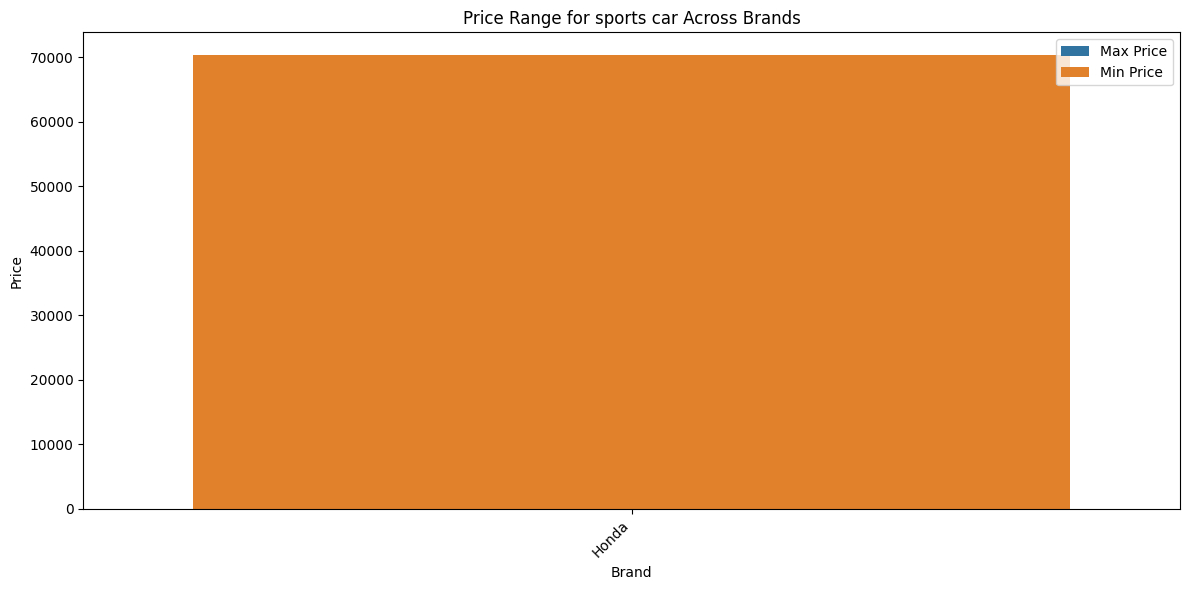

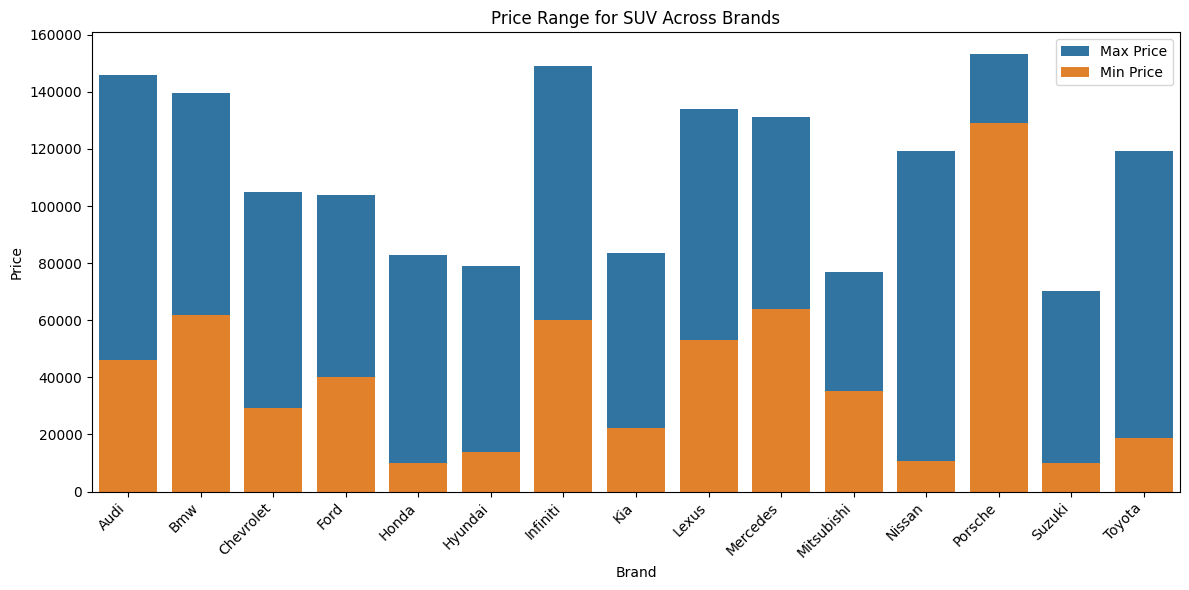

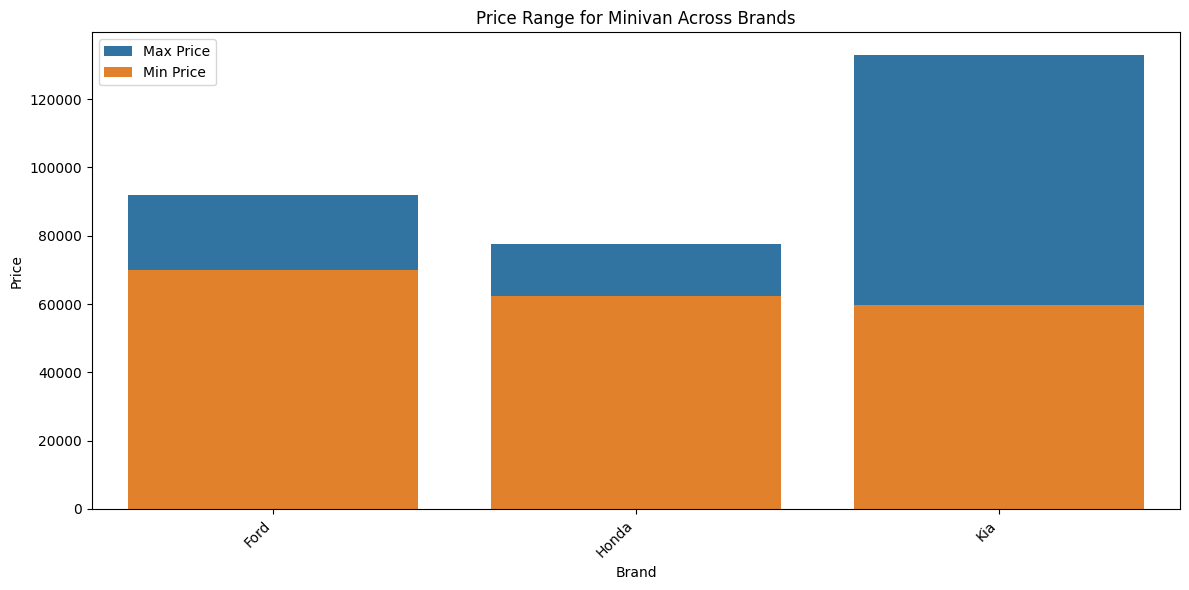

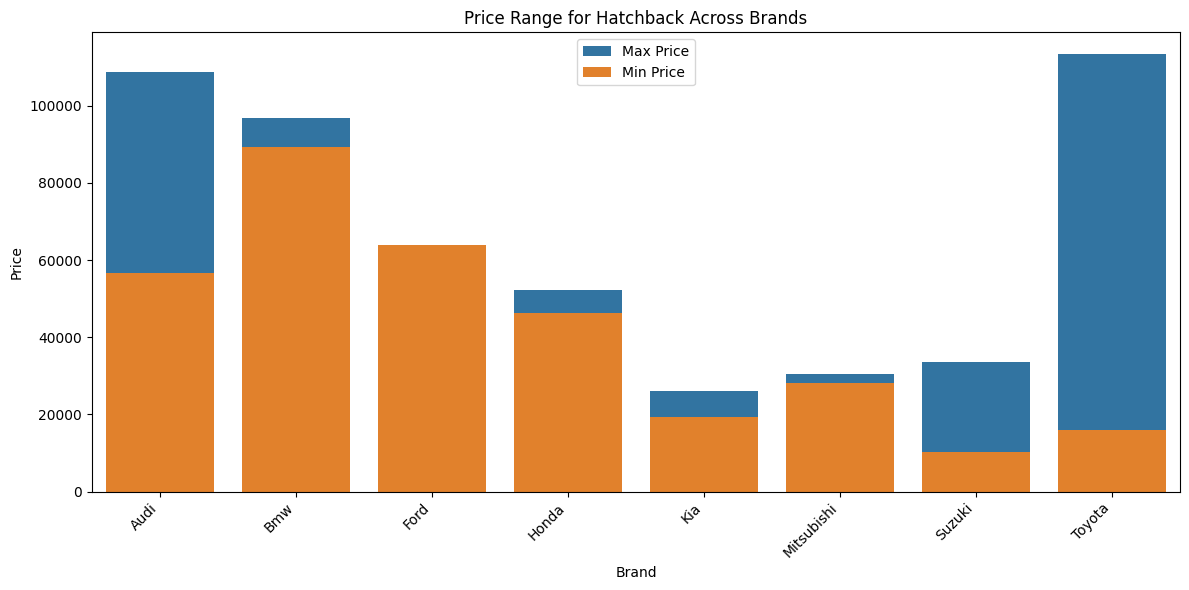

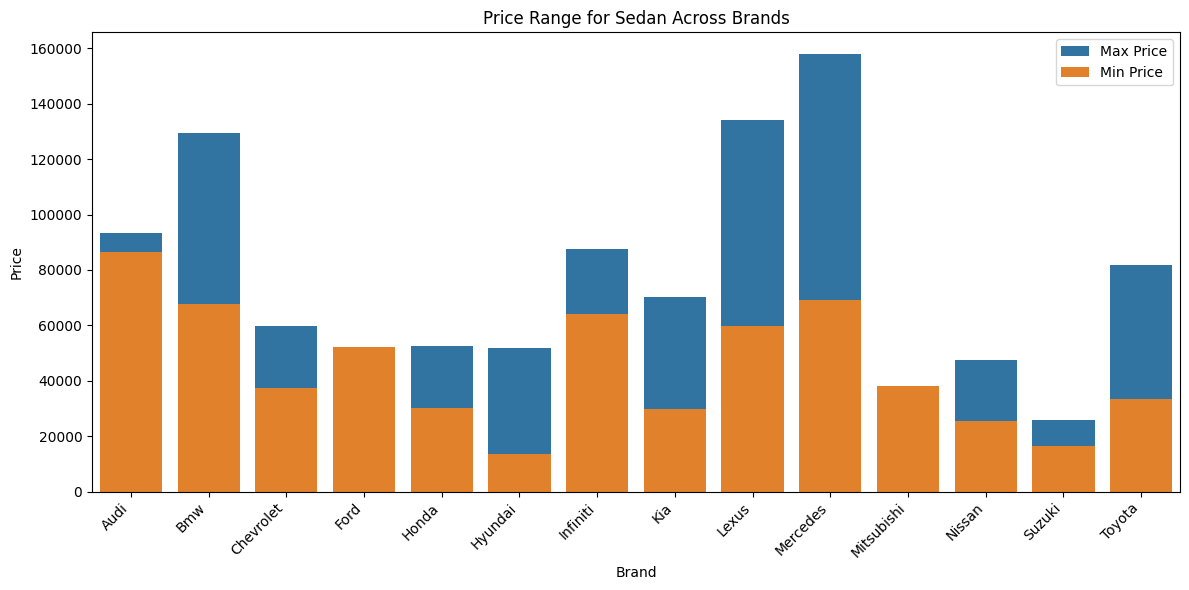

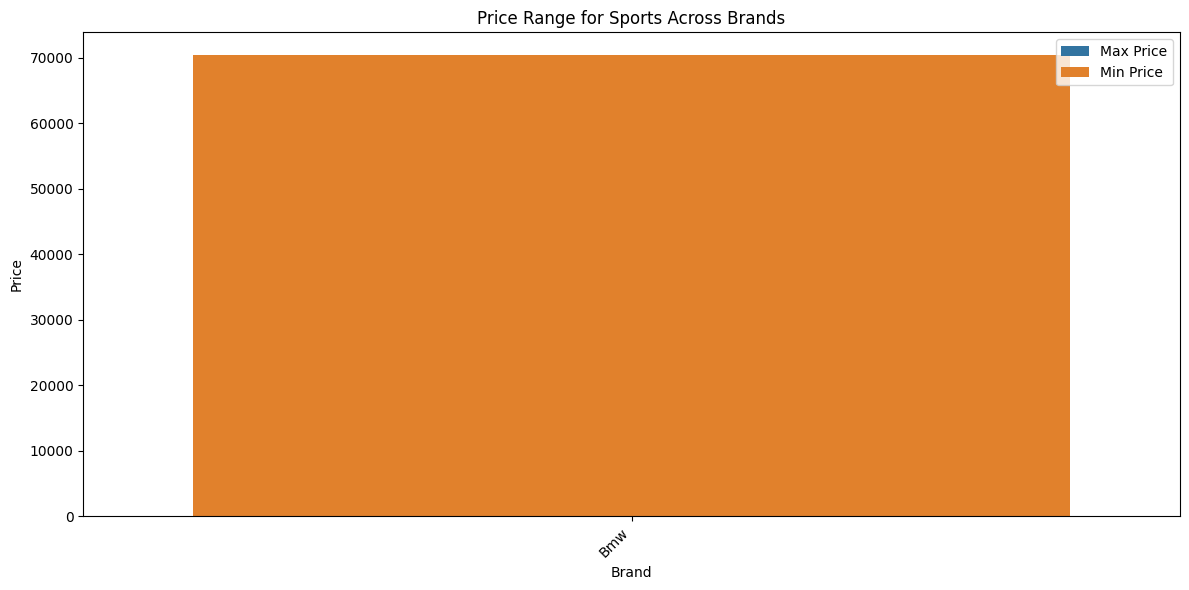

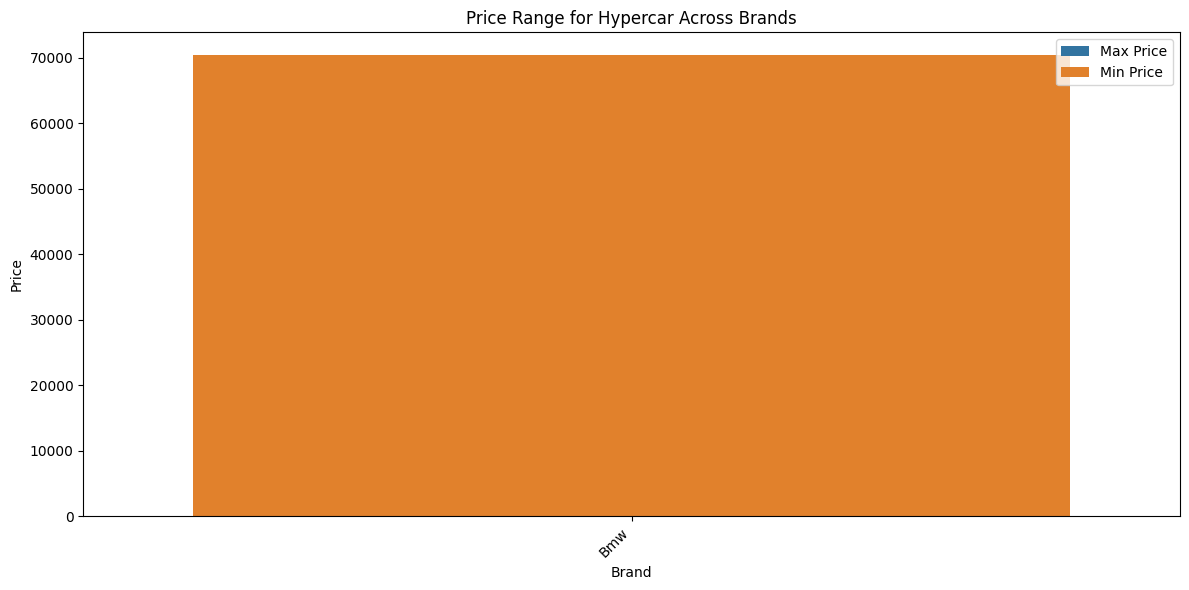

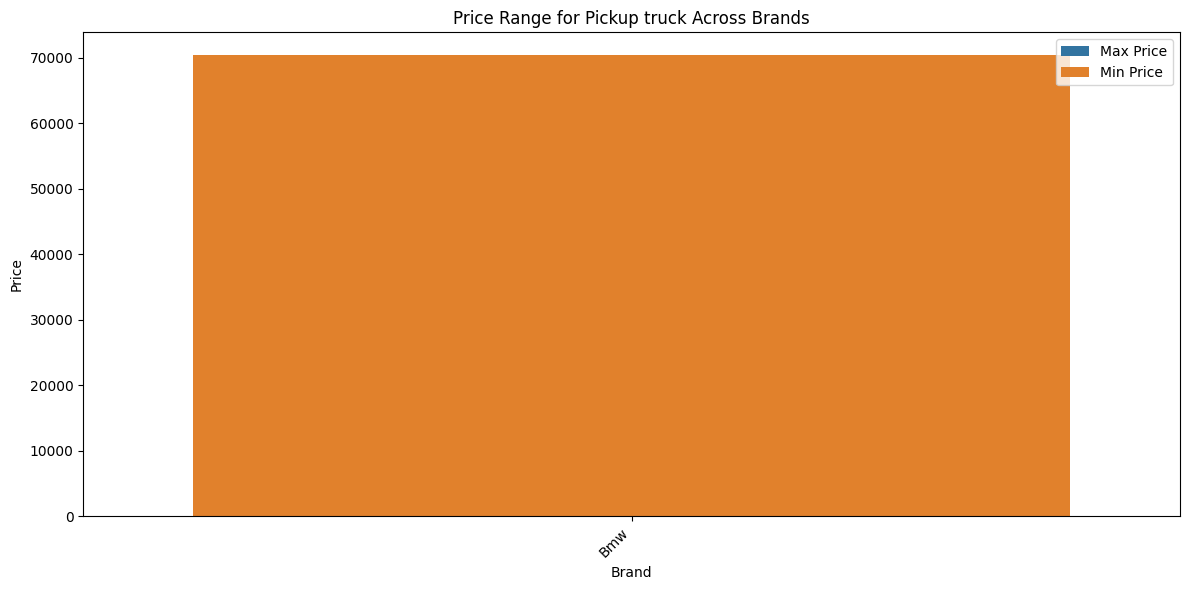

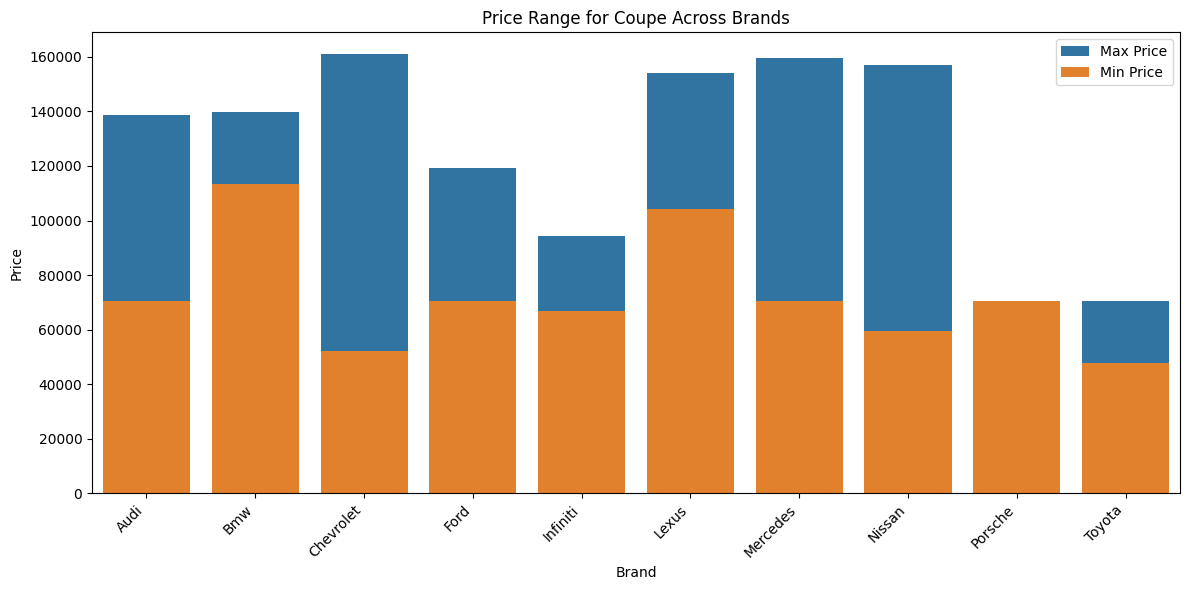

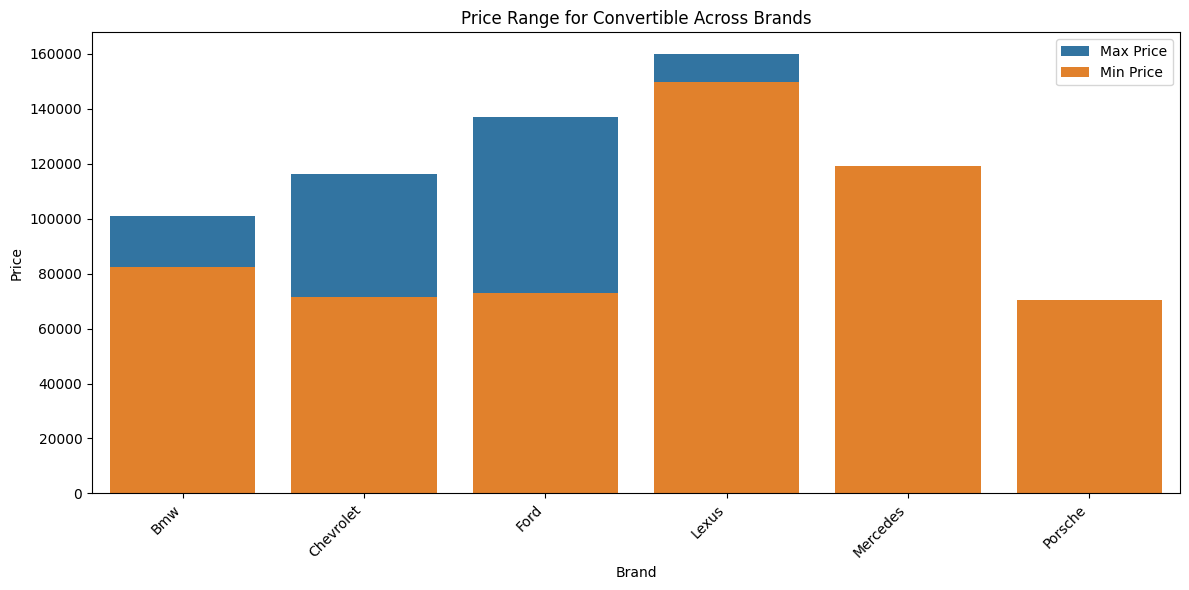

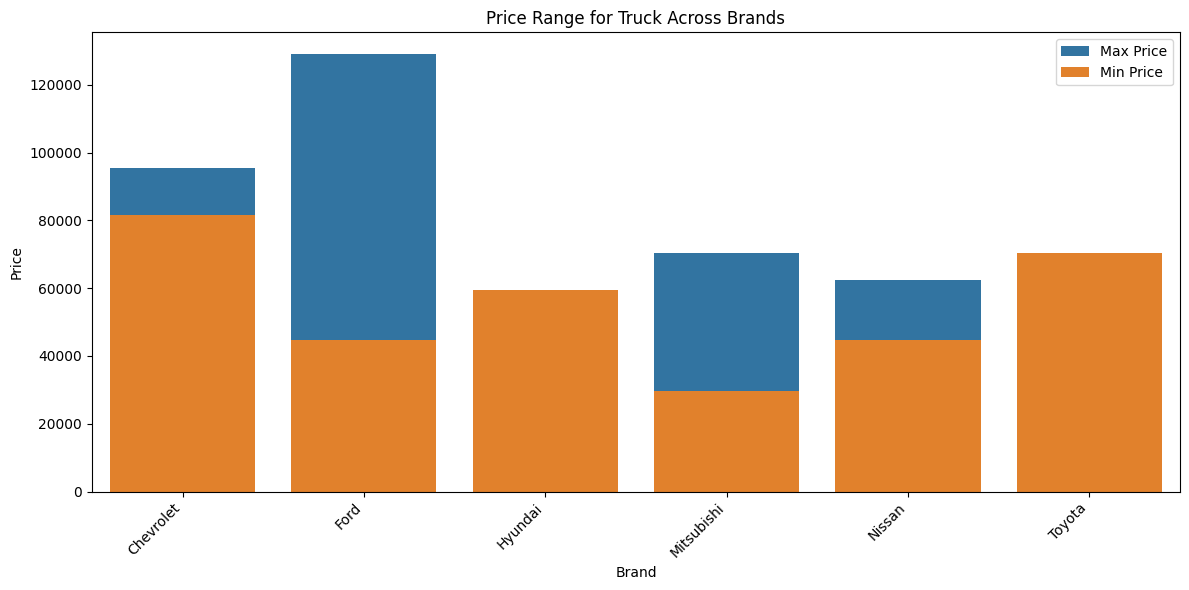

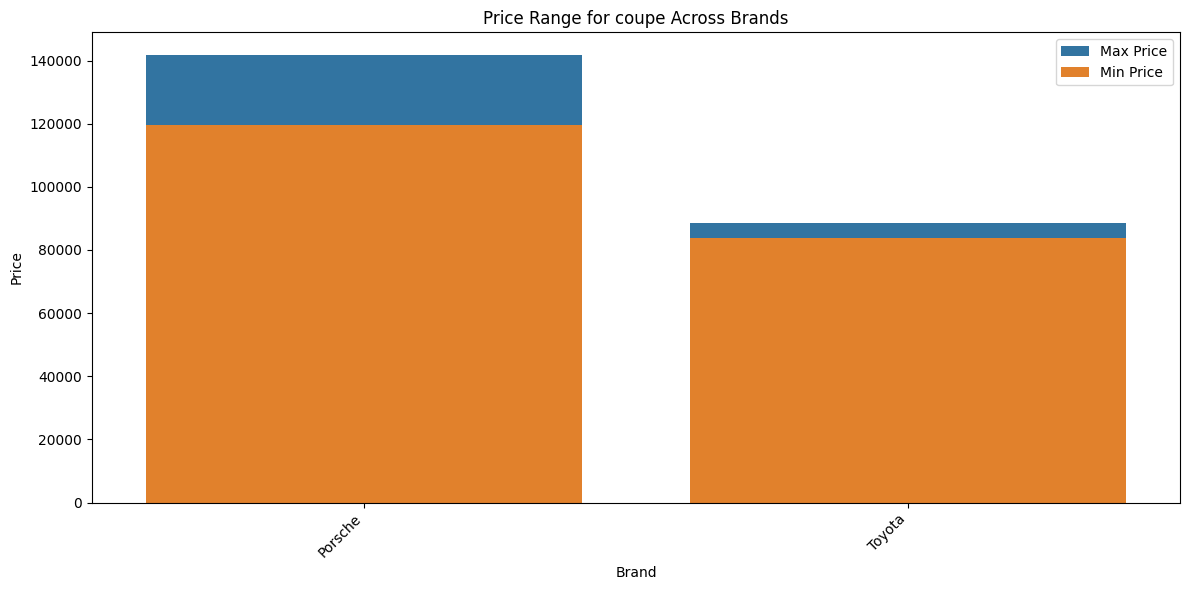

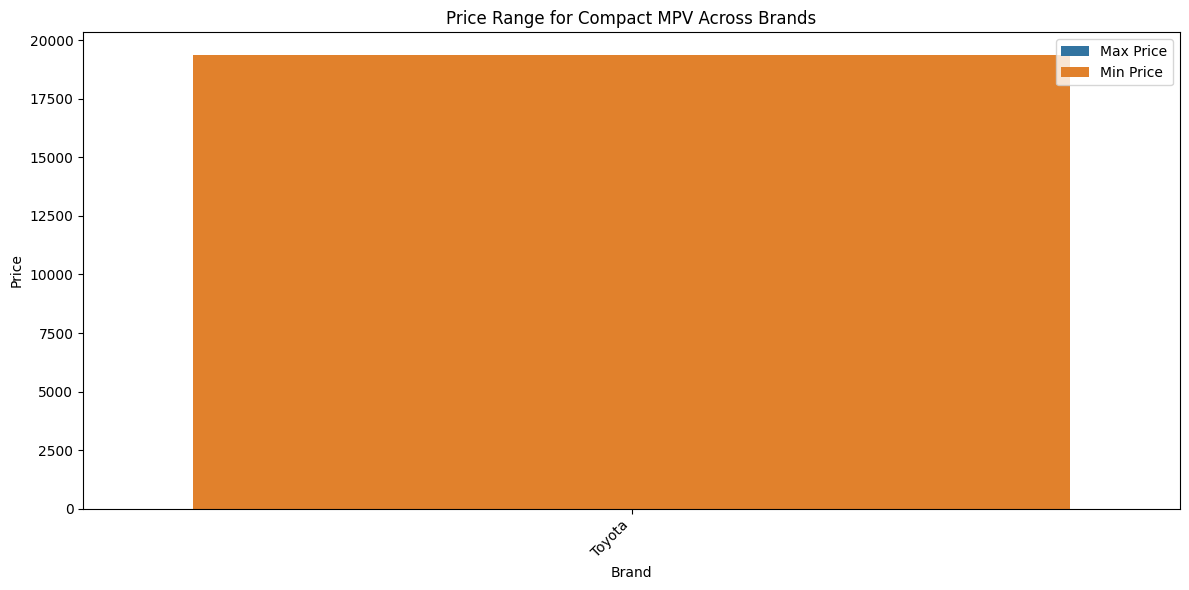

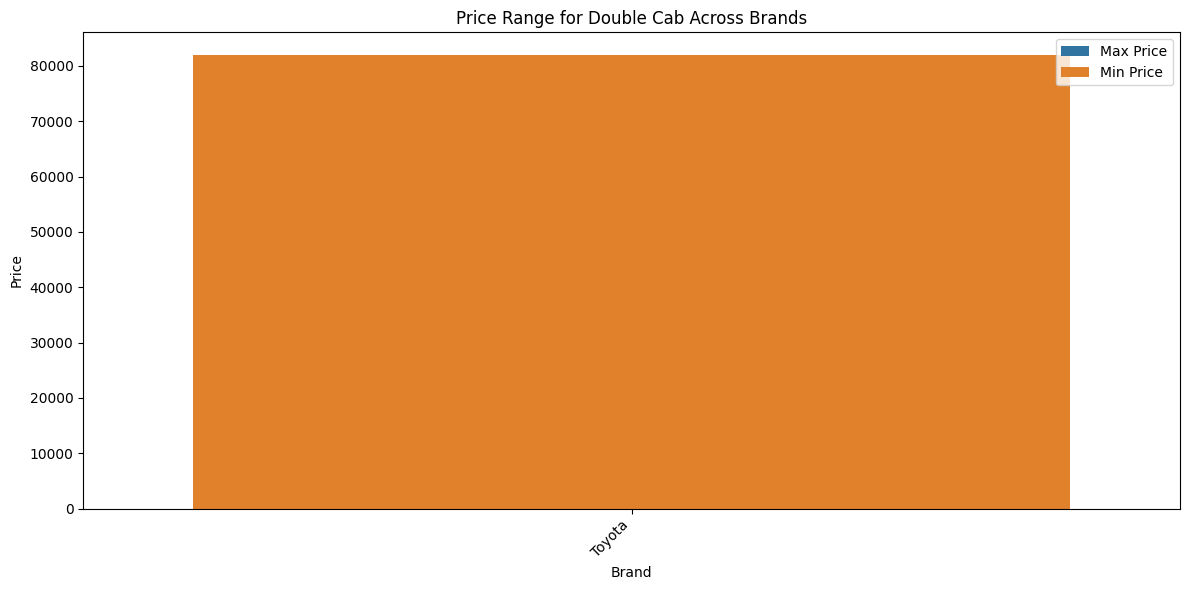

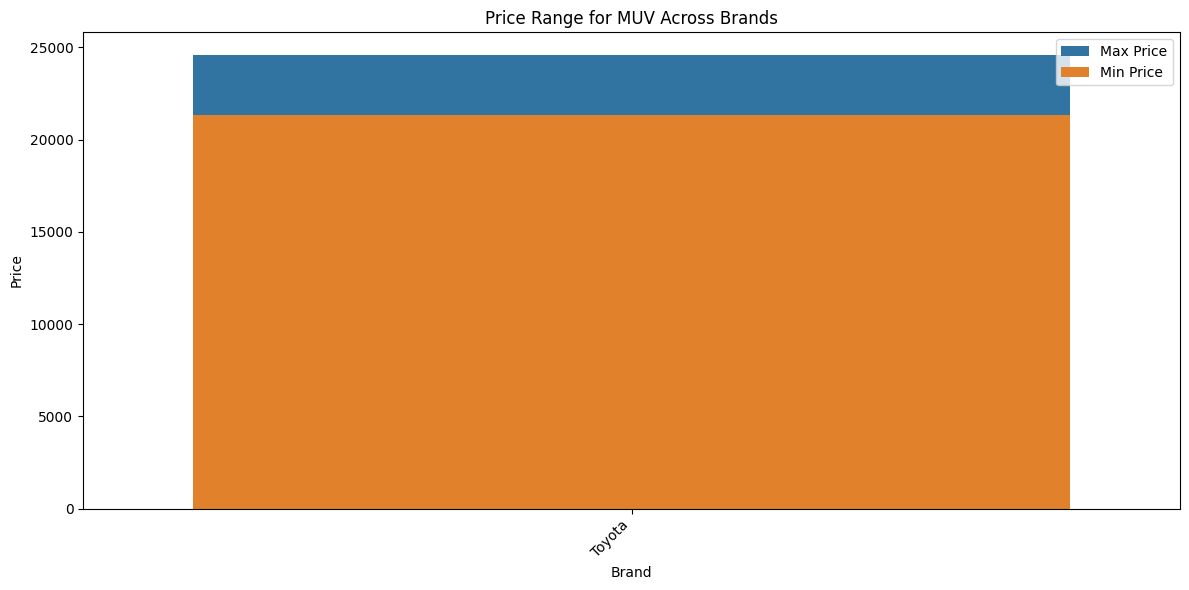

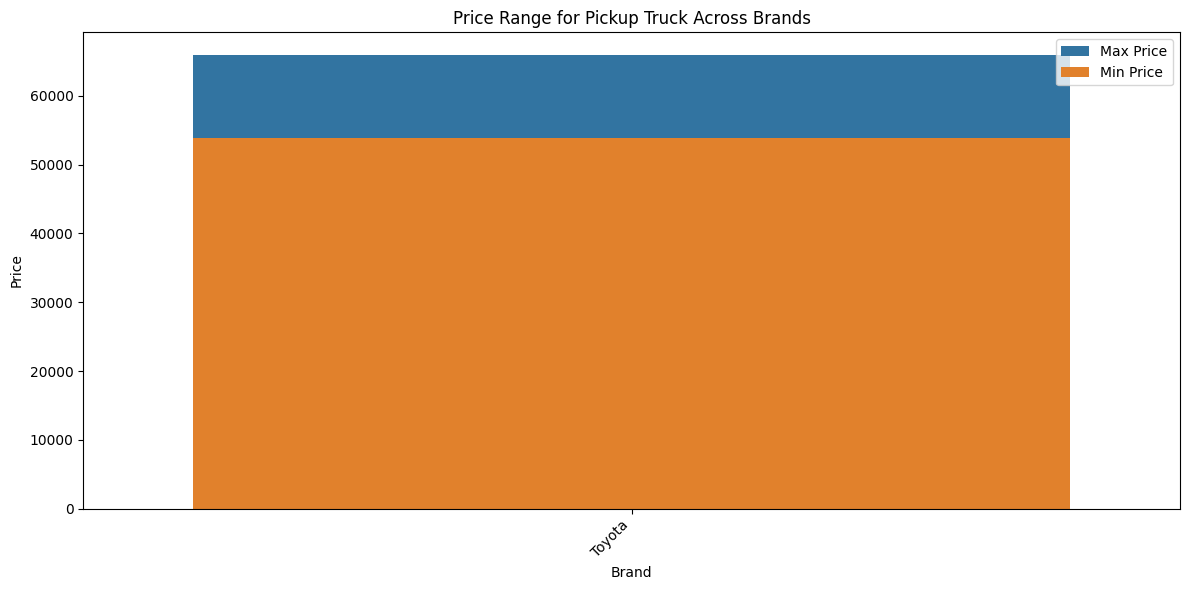

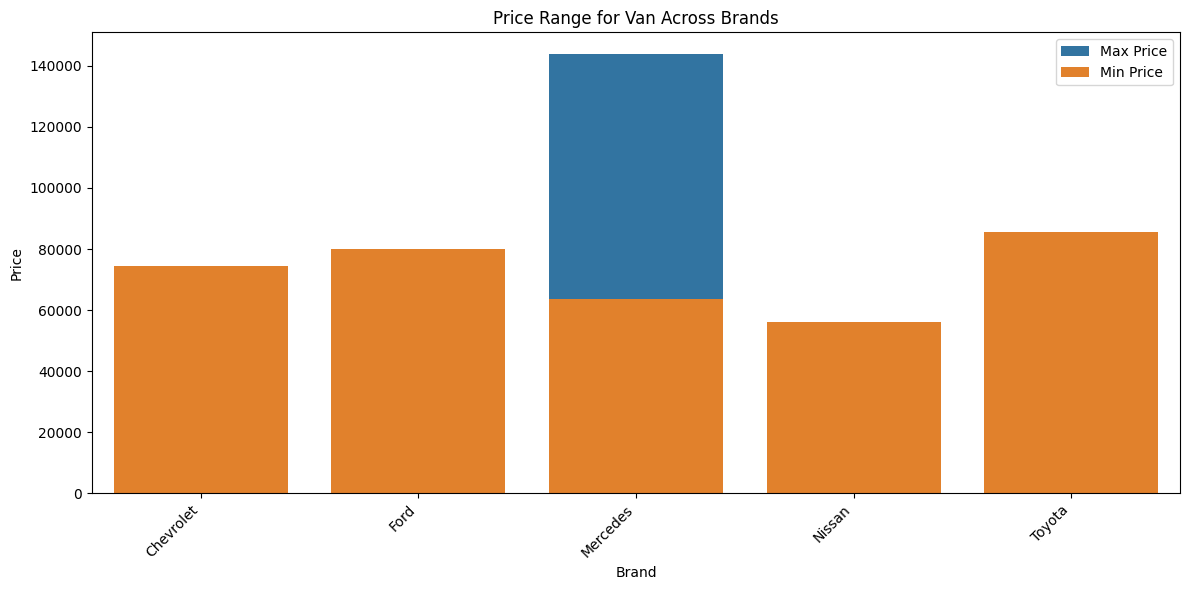

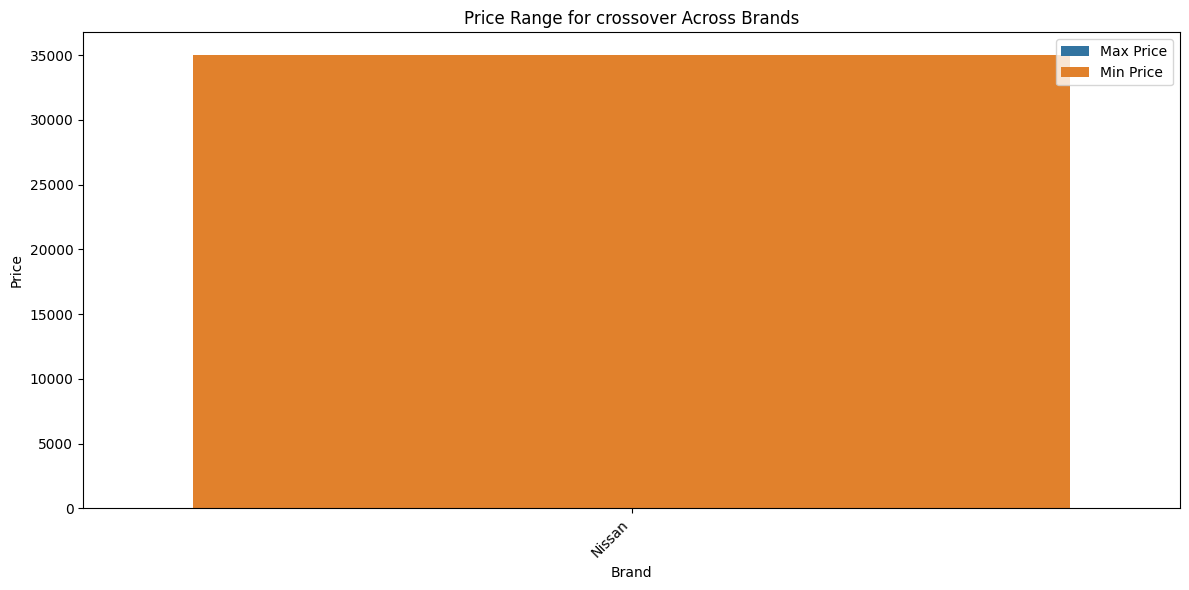

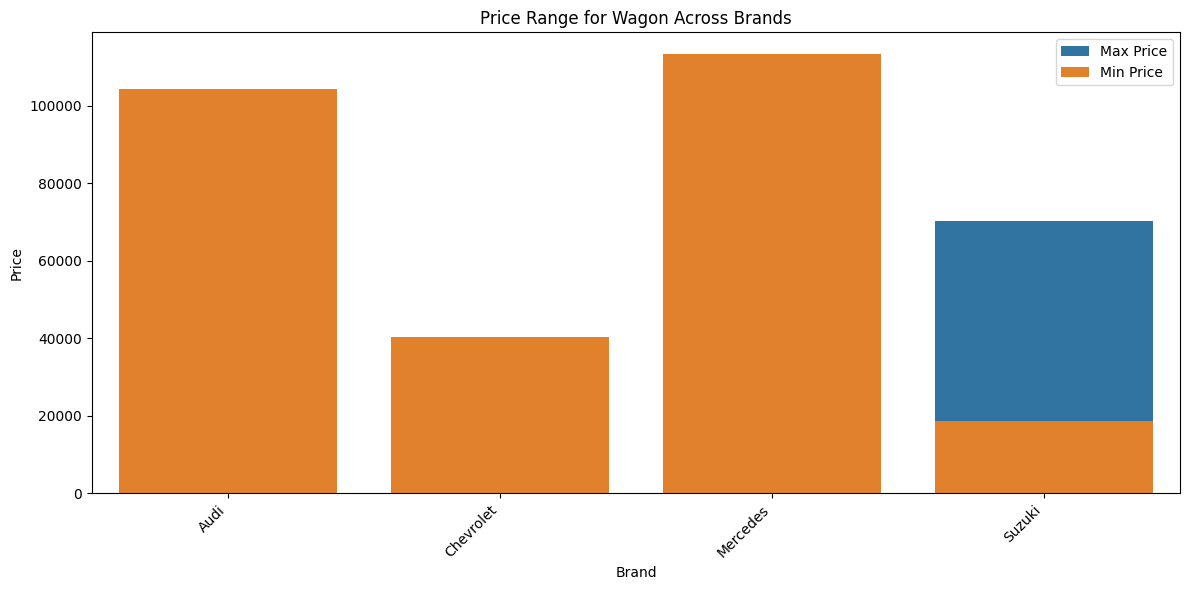

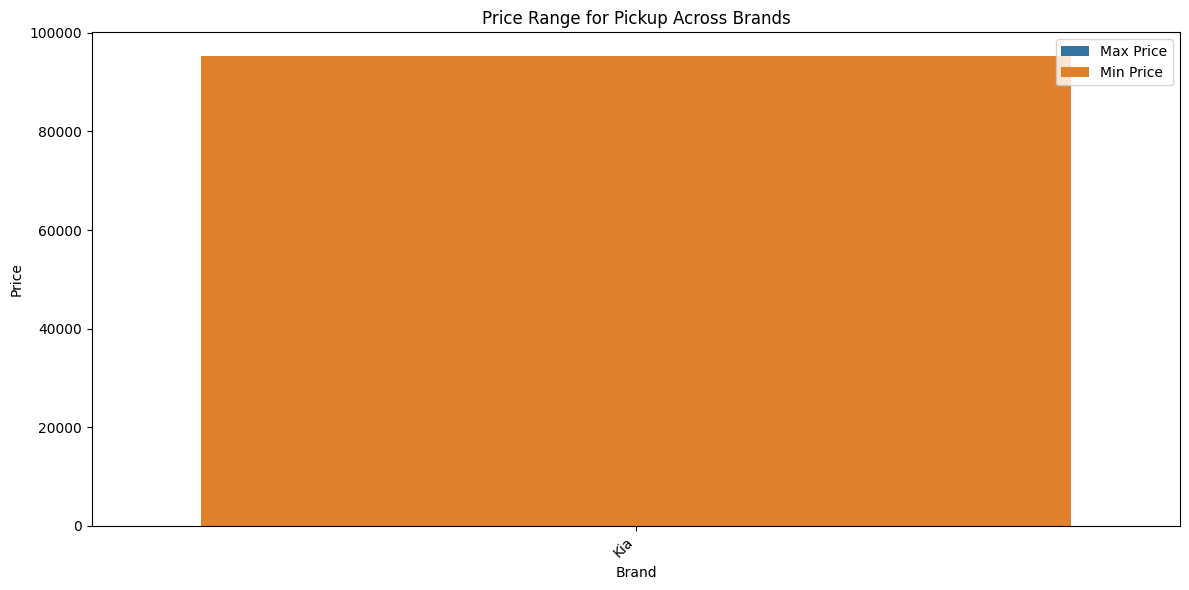

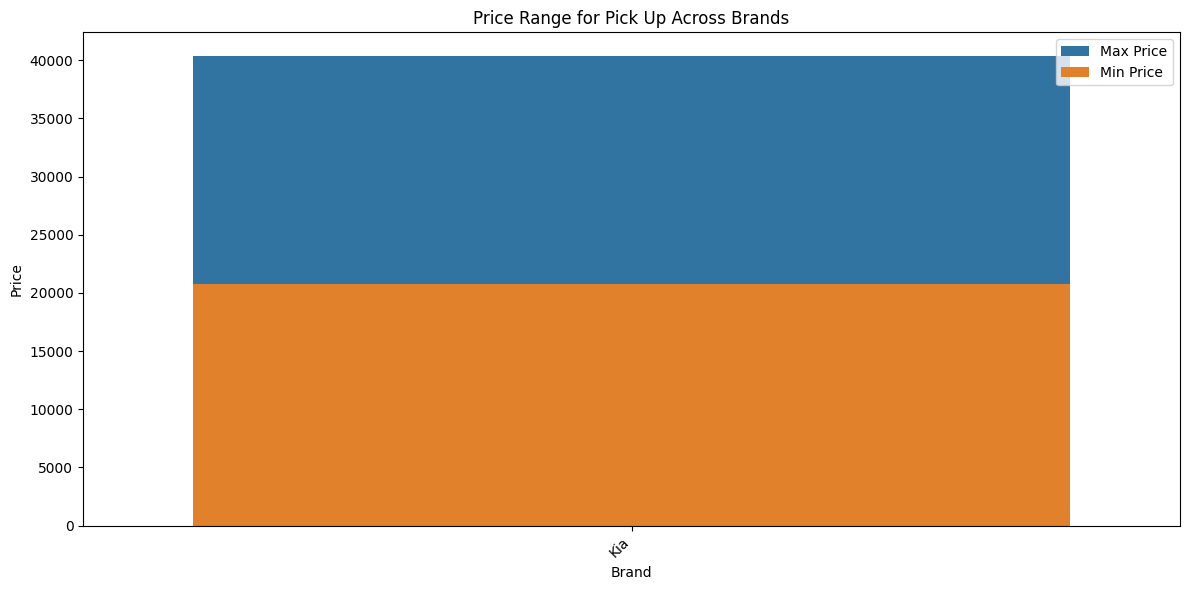

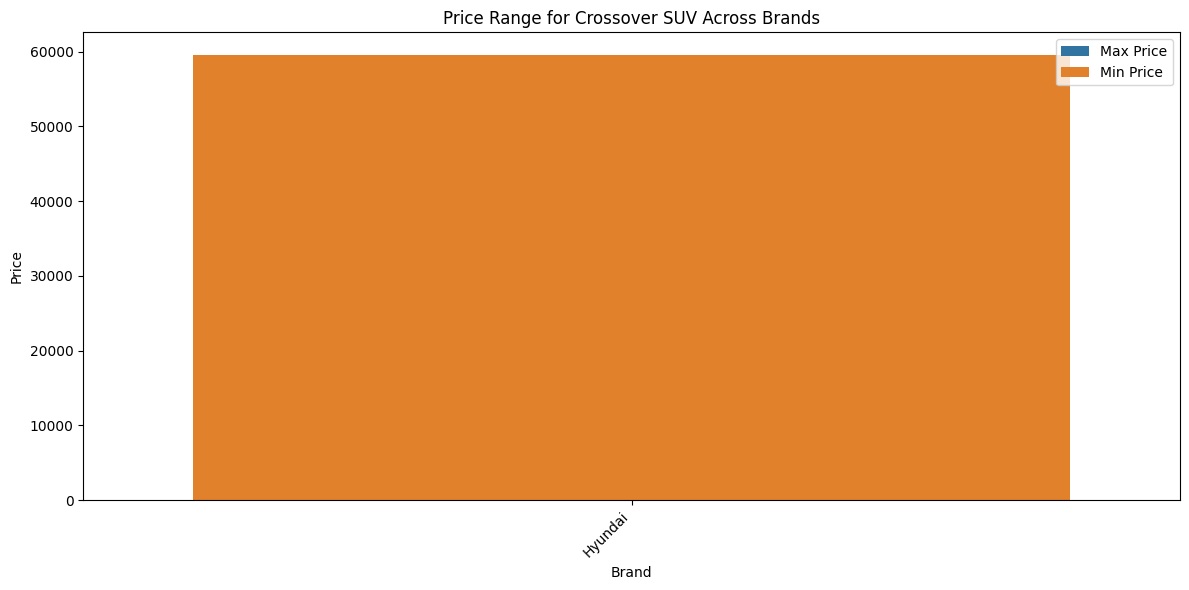

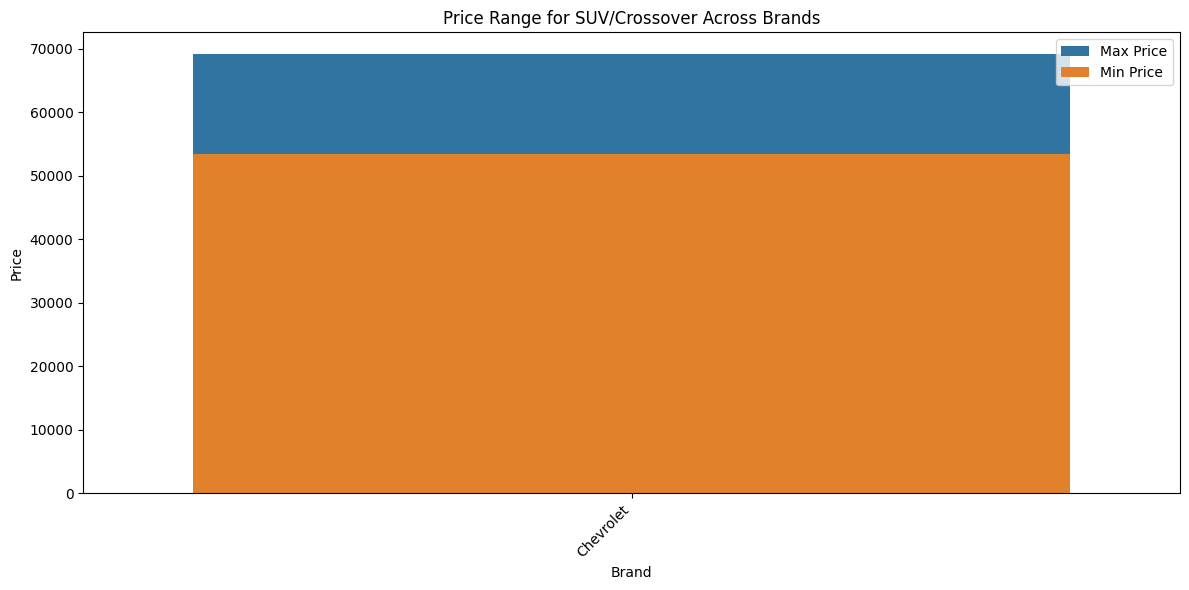

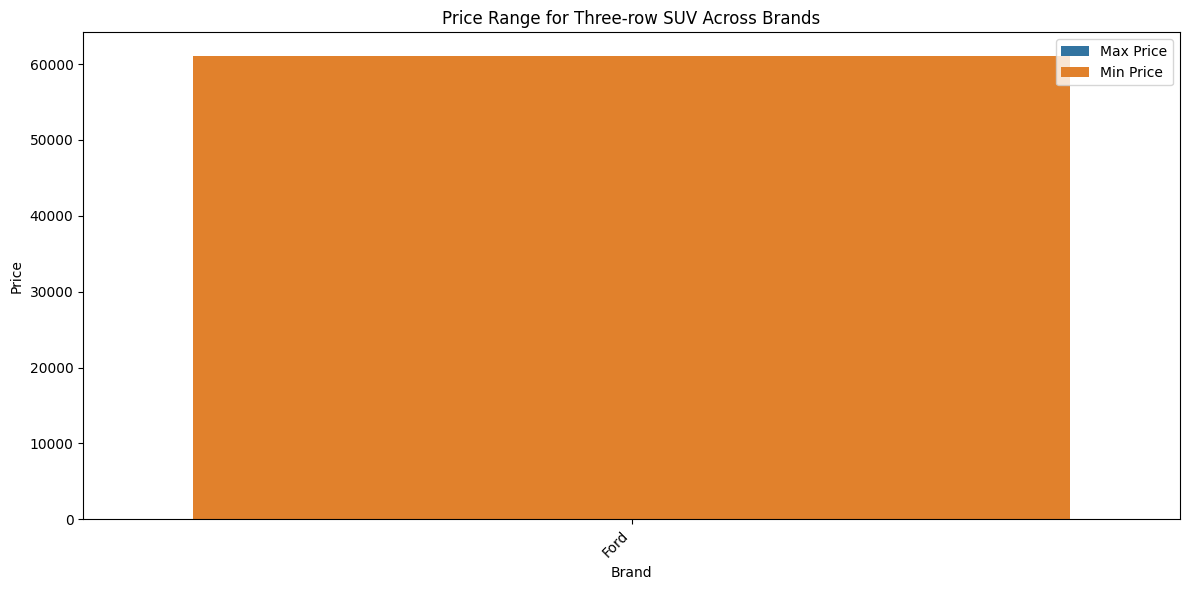

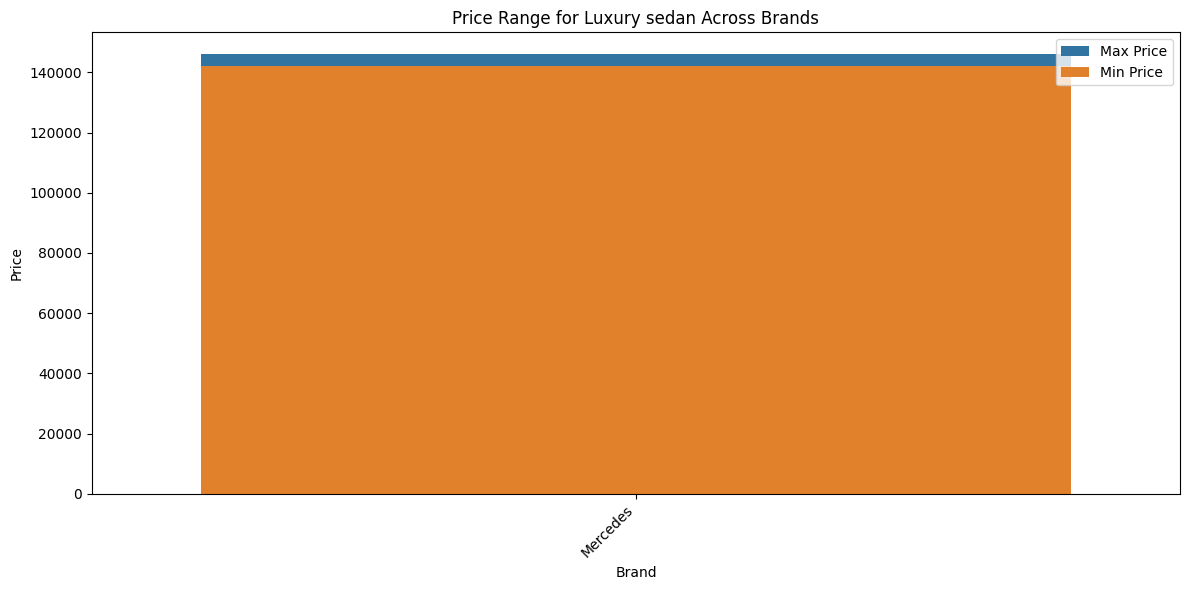

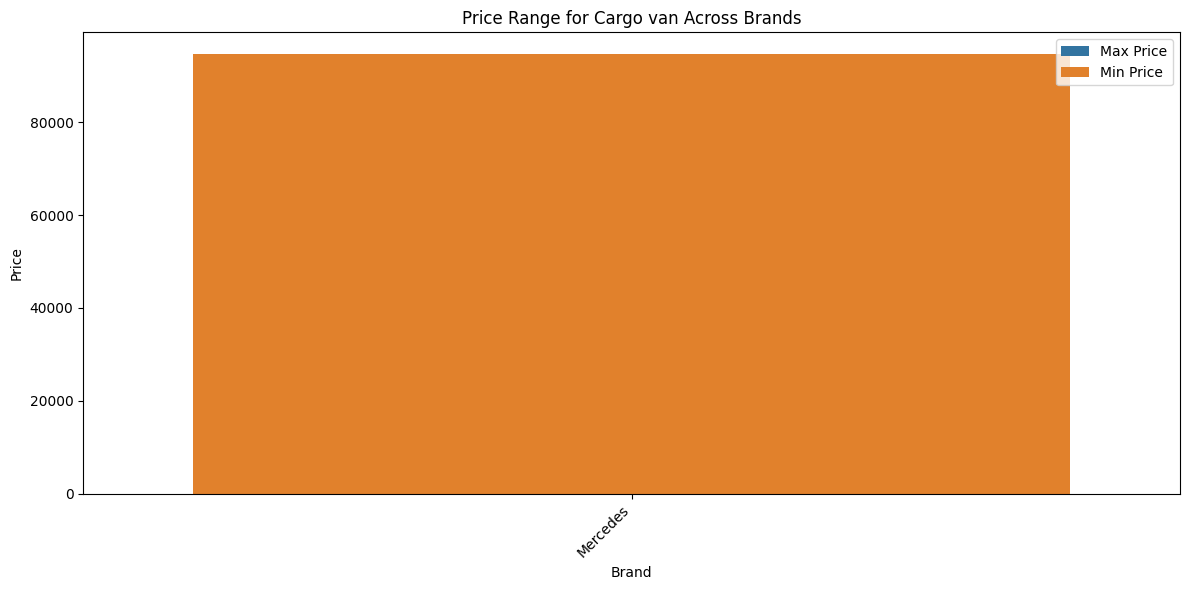

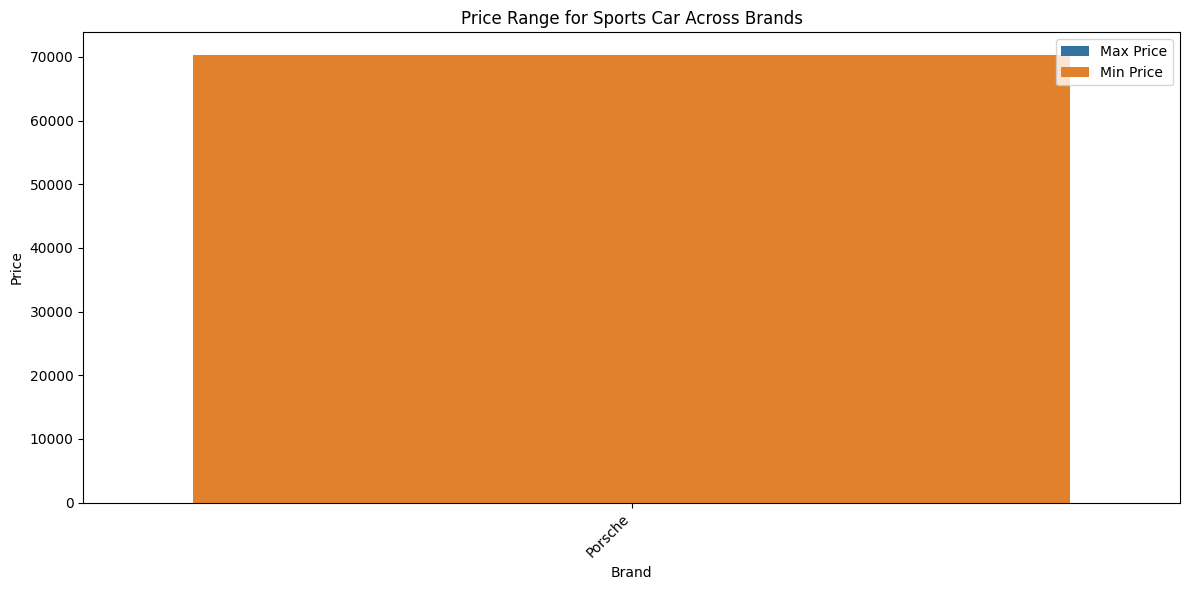

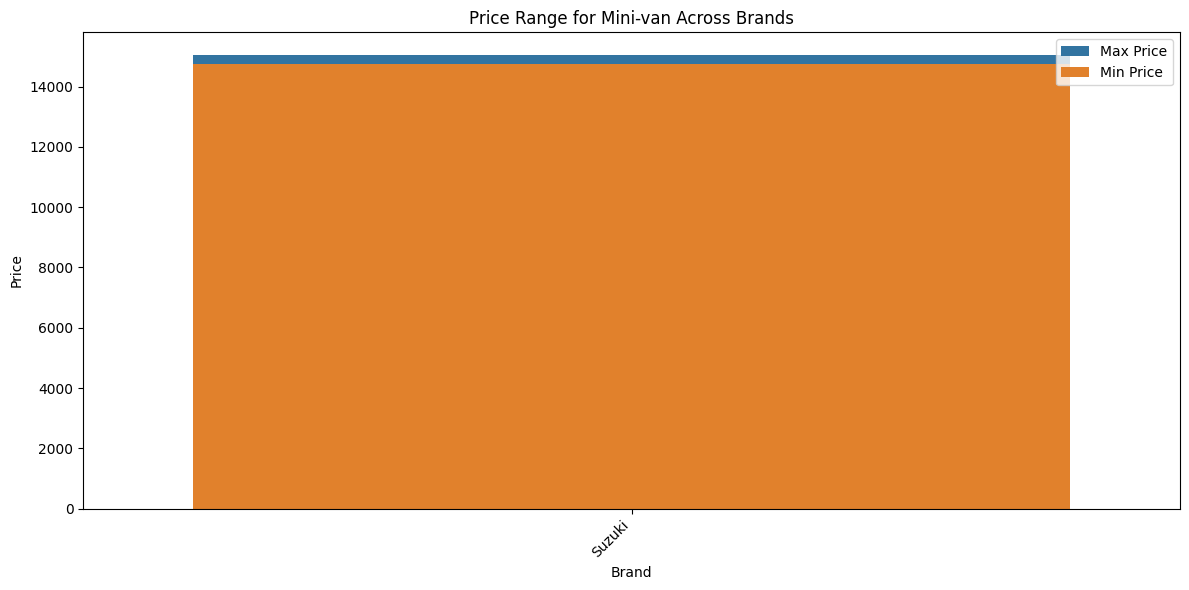

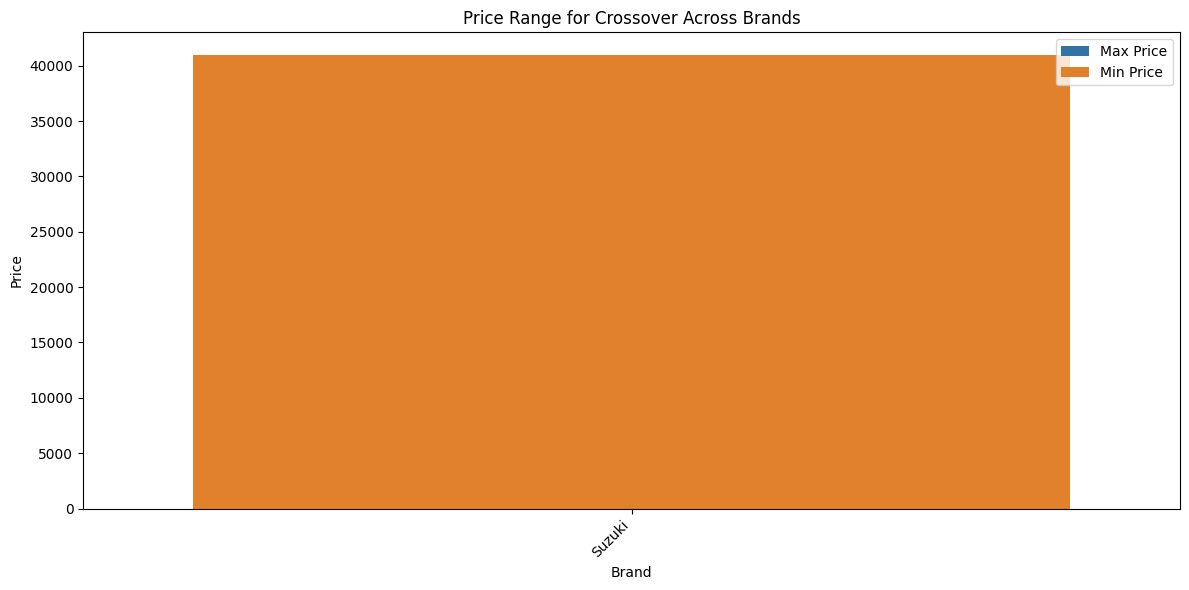

In [ ]:
price_ranges = Df.groupby(['body_type', 'brand'])['price'].agg(['min', 'max']).reset_index()

# Renaming columns for clarity
price_ranges = price_ranges.rename(columns={'min': 'Min Price', 'max': 'Max Price'})


# Function to create price range plots for each body type
def plot_price_ranges(body_type):
    body_type_df = price_ranges[price_ranges['body_type'] == body_type]
    plt.figure(figsize=(12, 6))
    sns.barplot(x='brand', y='Max Price', data=body_type_df, label='Max Price')
    sns.barplot(x='brand', y='Min Price', data=body_type_df, label='Min Price')
    plt.xlabel('Brand')
    plt.ylabel('Price')
    plt.title(f'Price Range for {body_type} Across Brands')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Get unique body types
body_types = Df['body_type'].unique()

# Create plots for each body type
for body_type in body_types:
    plot_price_ranges(body_type)

car brands and its prices from basic to luxury?

In [ ]:
import plotly.graph_objects as go

# Categorizing cars into 'Basic', 'Midrange', and 'Luxury'
price_thresholds = {'basic': 50000, 'midrange': 100000}

def categorize_car(price):
    if price <= price_thresholds['basic']:
        return 'Basic'
    elif price <= price_thresholds['midrange']:
        return 'Midrange'
    else:
        return 'Luxury'

Df['category'] = Df['price'].apply(categorize_car)

# Creating Heatmap using Plotly
fig = go.Figure(data=go.Heatmap(
    z=Df['price'],
    x=Df['brand'],
    y=Df['category'],
    colorscale='Viridis',
    text=Df['price'],
    texttemplate="%{text:.0f}",
    hovertemplate='Brand: %{x}<br>Category: %{y}<br>Price: %{z}<extra></extra>'
))

fig.update_layout(
    title='Car Prices by Brand and Category',
    xaxis_title='Brand',
    yaxis_title='Category',
    xaxis={'categoryorder': 'total descending'},
    yaxis={'categoryorder': 'category descending'}
)

fig.show()



# Insights

Price Range by Brand: There is a significant variation in price range across different electric car brands. Some brands, like Tesla, seem to position themselves primarily in the luxury category, while others offer electric cars in the basic and midrange segments as well.

Luxury Electric Car Brands: Based on the price thresholds you defined (basic: $50,000, midrange: $100,000), several brands appear in the luxury category, including Tesla, Porsche, Audi, and BMW.

Midrange Electric Car Brands: Some brands, like Chevrolet and Nissan, seem to offer electric cars in the midrange price range.

Basic Electric Car Brands: While the data might not show many brands in the basic category based on your thresholds, there might be a few electric car models from some brands that fall into this price range.





Which brand has the widest range of car prices?

In [ ]:
Df['price_range'] = Df.groupby('brand')['price'].transform(lambda x: x.max() - x.min())

# Find the brand with the widest price range
brand_with_widest_range = Df.loc[Df['price_range'].idxmax()]

# Create an interactive bar chart showing price ranges for each brand
fig = px.bar(Df.groupby('brand')['price_range'].max().reset_index(),
             x='brand', y='price_range',
             title='Price Range by Brand',
             labels={'brand': 'Car Brand', 'price_range': 'Price Range (AUD)'},
             text='price_range')
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.show()

print(f"The brand with the widest price range is: {brand_with_widest_range['brand']}")

The brand with the widest price range is: Nissan


# Insights

The Bar chart illustrates the price range of different car brands in Australian Dollars (AUD). It's evident that there's a substantial variation in price ranges across these brands.

--> Porsche Dominates: Porsche stands out with the widest price range, indicating a diverse lineup of models, possibly ranging from entry-level sports cars to high-end luxury vehicles.


--> Luxury Brands: Brands like Mercedes, Lexus, and BMW have relatively high price ranges, reflecting their positioning as luxury car manufacturers.


--> Mid-Range Brands: Brands like Toyota, Honda, and Hyundai offer a mix of affordable and premium models, resulting in a moderate price range.


--> Budget-Friendly Brands: Brands like Chevrolet, Ford, and Suzuki have lower price ranges, suggesting a focus on affordable and entry-level vehicles.

What is the distribution of body types across brands?

In [ ]:
body_type_counts = Df.groupby(['brand', 'body_type']).size().reset_index(name='count')

fig = px.treemap(body_type_counts,
                 path=['brand', 'body_type'],
                 values='count',
                 title='Distribution of Body Types Across Brands',
                 color='count',
                 hover_data=['brand', 'body_type', 'count'])
fig.show()

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:718: UserWarning:

Using the countplot function without specifying `order` is likely to produce an incorrect plot.



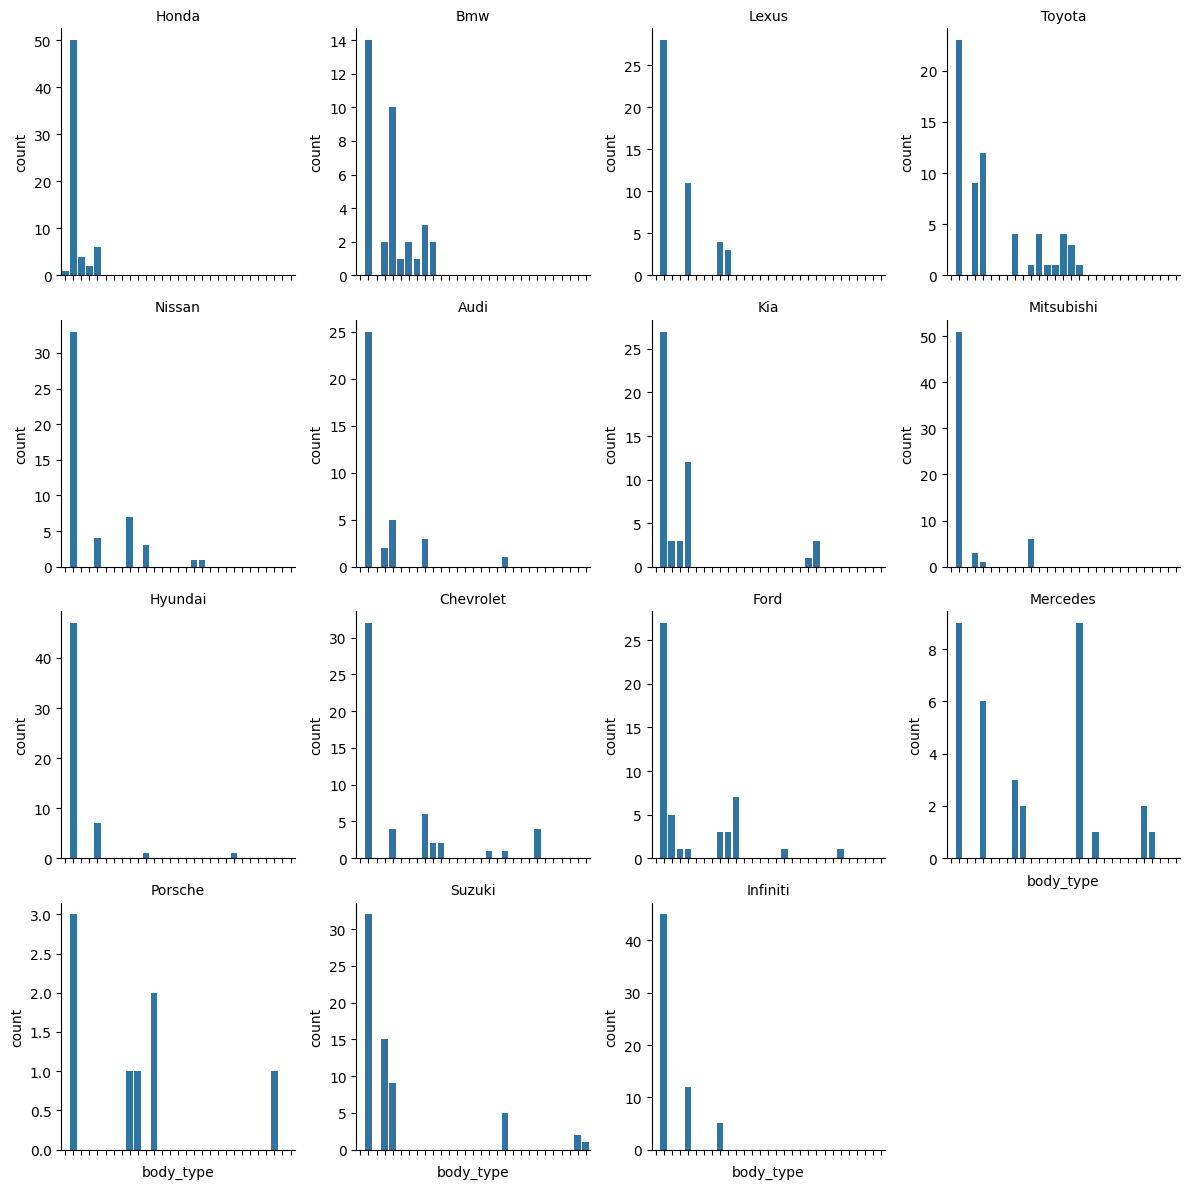

In [ ]:
g = sns.FacetGrid(Df, col='brand', col_wrap=4, height=3, sharey=False)
g.map(sns.countplot, 'body_type')
g.set_xticklabels(rotation=45, ha='right')
g.set_titles(col_template="{col_name}")
plt.tight_layout()
plt.show()

Overall Distribution:

--> SUV Dominance: SUVs seem to be the most popular body type across multiple brands, with a significant portion of the treemap dedicated to them. This suggests a strong consumer preference for SUVs.


--> Sedan Presence: Sedans are also well-represented, indicating a consistent demand for this traditional car body type.


--> Variety of Body Types: The treemap shows a diverse range of body types, including coupes, convertibles, trucks, and vans, though they might be less prevalent compared to SUVs and sedans.

Brand-Specific Observations:

--> Brand-Specific Preferences: Some brands might have a stronger focus on specific body types. For example, Porsche seems to have a higher proportion of coupes and convertibles compared to other brands.


--> Brand Diversity: Brands like Toyota and Hyundai offer a wider range of body types, catering to different consumer preferences.

What is the average fuel type and Drive type?


In [ ]:
pivot_table = Df.pivot_table(index='brand', columns=['fuel_type', 'drive_type'], values='price', aggfunc='mean')

fig = px.imshow(pivot_table,
                labels=dict(x="Fuel Type & Drive Type", y="Brand", color="Average Price"),
                x=pivot_table.columns,  # Set x-axis labels to fuel/drive type combinations
                y=pivot_table.index,  # Set y-axis labels to car brands
                title='Average Car Price by Brand, Fuel Type, and Drive Type')
fig.show()

# Insights

--> Price Range: The color bar indicates the average price range for each combination of brand, fuel type, and drive type. Darker colors represent higher average prices, while lighter colors represent lower average prices.


--> Brand-Specific Trends: Some brands consistently have higher average prices across different fuel types and drive types, indicating a premium positioning. Others might have a wider range of prices, catering to different segments of the market.


--> Fuel Type and Drive Type Impact: The combination of fuel type and drive type can significantly influence the average price. For example, hybrid and electric vehicles often have higher average prices compared to gasoline-powered vehicles.

Fuel Type vs. Body Type?


In [ ]:
average_fuel_type = Df['fuel_type'].mode()[0]
average_drive_type = Df['drive_type'].mode()[0]


print(f"Average Fuel Type: {average_fuel_type}")
print(f"Average Drive Type: {average_drive_type}")

# Plotting the average fuel type
fuel_type_counts = Df['fuel_type'].value_counts().reset_index()
fuel_type_counts.columns = ['Fuel Type', 'Count']

fig_fuel = px.bar(fuel_type_counts, x='Fuel Type', y='Count', title='Fuel Type Distribution')
fig_fuel.show()


# Plotting the average drive type
drive_type_counts = Df['drive_type'].value_counts().reset_index()
drive_type_counts.columns = ['Drive Type', 'Count']

fig_drive = px.bar(drive_type_counts, x='Drive Type', y='Count', title='Drive Type Distribution')
fig_drive.show()

Average Fuel Type: Gasoline
Average Drive Type: All-Wheel Drive


# Insights

Dominant Fuel Type:

--> Gasoline is the most prevalent fuel type, with a significantly higher count compared to other types. This suggests that gasoline-powered vehicles are the most common in the dataset.


Other Fuel Types:

--> Petrol and Diesel are also relatively common, indicating a significant presence of these fuel types.

--> Hybrid and Electric fuel types have a lower count, suggesting a smaller proportion of hybrid and electric vehicles in the dataset.


--> Other Fuel Types: There are several other fuel types with very low counts, such as CNG, LPG, and ethanol, indicating their limited presence in the dataset.

Price vs. Transmission Type?


<ipython-input-61-b6db6815ceab>:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




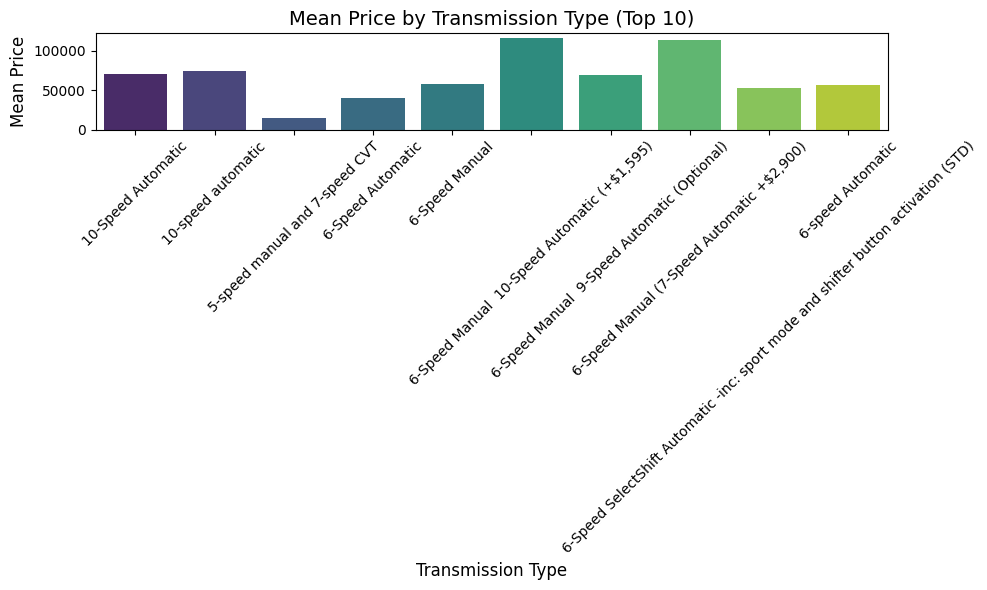

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by 'transmission_type' and calculate summary statistics
summary_stats = Df.groupby('transmission_type')['price'].describe().reset_index().head(10)

# Bar Plot for Mean Price (top 10 rows)
plt.figure(figsize=(10, 6))
sns.barplot(data=summary_stats, x='transmission_type', y='mean', palette="viridis")
plt.title('Mean Price by Transmission Type (Top 10)', fontsize=14)
plt.xlabel('Transmission Type', fontsize=12)
plt.ylabel('Mean Price', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Automatic Transmissions Dominate:

The majority of transmission types are automatic, with various speed options. This suggests a strong preference for automatic transmissions among buyers.


Mean Price Variation:

There is a significant variation in mean prices across different transmission types, indicating that transmission type can be a major factor in determining vehicle cost.






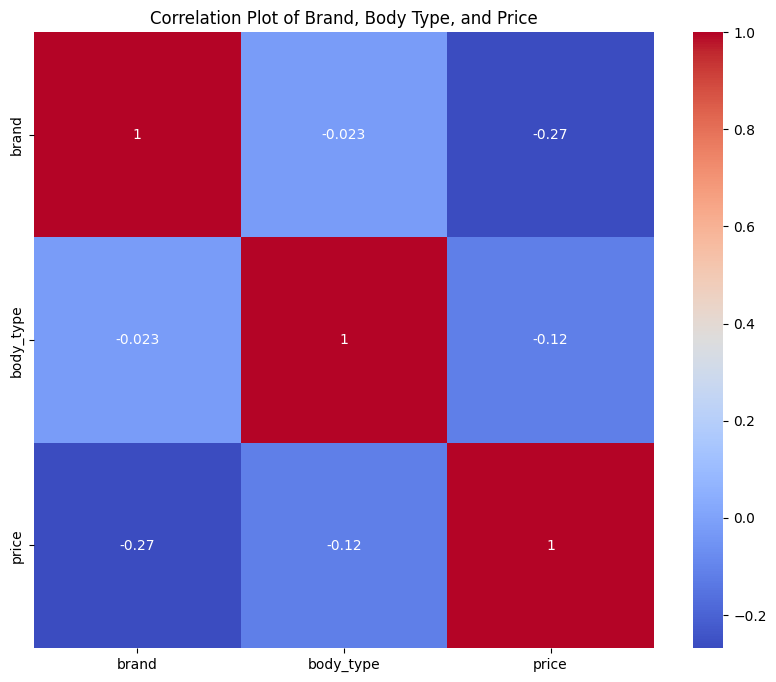

In [ ]:
encoded_df = Df.copy()
encoded_df['brand'] = encoded_df['brand'].astype('category').cat.codes
encoded_df['body_type'] = encoded_df['body_type'].astype('category').cat.codes
plt.figure(figsize=(10, 8))
sns.heatmap(encoded_df[['brand', 'body_type', 'price']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Plot of Brand, Body Type, and Price')
plt.show()


In [ ]:
import plotly.express as px
import pandas as pd

# Assuming Df is your DataFrame and already loaded
Df['price'] = pd.to_numeric(Df['price'], errors='coerce')  # Ensure price is numeric
Df['brand'] = Df['brand'].astype('category')  # Ensure brand is categorical
Df['body_type'] = Df['body_type'].astype('category')  # Ensure body_type is categorical

# Create a density heatmap with a valid Plotly colorscale
fig = px.density_heatmap(
    data_frame=Df,
    x='brand',
    y='body_type',
    z='price',
    histfunc='avg',  # Use average price for the heatmap
    title='Heatmap of Price by Brand and Body Type',
    color_continuous_scale='Viridis',  # A supported Plotly colorscale
    labels={'price': 'Average Price'}  # Label for the color bar
)

# Show the heatmap
fig.show()



In [ ]:
# Filter the cleaned dataset to exclude electric cars
cleaned_data_no_electric = cleaned_data[cleaned_data['fuel_type'].str.lower() != 'electric']

# Save the updated dataset
output_path_no_electric = 'cleaned_car_details_no_outliers_no_electric.csv'
cleaned_data_no_electric.to_csv(output_path_no_electric, index=False)

print(f"Updated dataset (without electric cars) saved as '{output_path_no_electric}'")


Updated dataset (without electric cars) saved as 'cleaned_car_details_no_outliers_no_electric.csv'
